# Exploración datos proyecto Machine Learning ESVAL S.A.
**Joaquín Farias, Practicante ESVAL**

**Proyecto con PUCV: Clasificación de refacturas**

**Versión: 18.11.2020**

En este Notebook se exploraran los datos de la base de datos incluida en el archivo "2016-2018v3.csv". Para hacer esto se dispone de los siguientes pasos:
1. Explicación del problema.
2. Carga y explicación de las caracteristicas de cada columna.
3. Análisis de valores nulos.
4. Análisis y filtrado de datos atipicos.
5. Detectar correlaciónes entre columnas.
6. Grafica de algunas columnas para tener una idea de las relaciones.
7. Árbol de decisión y analisis PCA (Principal Component Analysis).
8. Proposición de modificación tentativa de datos.
9. Conclusiones.


### 1. Explicación del problema
El problema que intenta solucionarse con este proyecto es simplificar la decisión de los analistas a la hora de tomar una acción respecto de las lecturas y otras caracteristicas relacionadas con las columnas de la base de datos. Ante el problema de fallo y de complicaciones desicir una acción este proyecto pretende dar una probabilidad de que la lectura de tal cliente tenga o no una refactura.
Se describe a grandes rasgos el flujo de este proceso en la empresa incluyendo donde se aplicaria el modelo (esto puede cambiar dependiendo de decisiones posteriores).}


### 2. Carga y explicación de las caracteristicas de cada columna
Para poder cargar la base de datos en python y dado su gran tamaño, se opto por separa los datos en 3 archivos del mismo tamañano. Así se logra un tamaño mas manejable de los datos.

In [3]:
#Ocupar solo si no se tienen los chunks desde antes 

import pandas as pd

#parametros
filename = r'2016-2018v3.csv'
chunk_size = 10115981 #se escogio este numero para lograr 3 lotes con la misma cantidad de filas

#separar los datos y crear los 3 archivos de estas separaciones
batch_no=0
for chunk in pd.read_csv(filename,chunksize=chunk_size):
    chunk.to_csv('chunk'+str(batch_no+1)+'_2016-2018v3.csv',index=False)
    print('Se creo chunk'+str(batch_no+1)+'_2016-2018v3.csv')
    batch_no+=1

Se creo chunk1_2016-2018v3.csv
Se creo chunk2_2016-2018v3.csv
Se creo chunk3_2016-2018v3.csv


#### Explicación de columnas
Se debe notar que la base de datos la conforman 28 columnas dentro de las cuales 27 son de caracteristicas y 1 de etiqueta (TIENE_REFA). A continuacion se hace una breve descripción de todas las columnas:

**1. NRO_SUMINISTRO:** Numero de identificador de cada cliente (unico para cada registro).


**2. COD_DIAMETRO:**  Codigo del diametro de cada medidos, el mas comun en zona recidencial es 13. Esta relacionado con el flujo de agua que tiene cada medido, y a su vez con el consumo.


**3. LECTURA:** Lectura final del mes actual que se hace el analista viendo lecturas de varias fuentes.


**4. LECTURA_TERRENO:** Es la primera lectura que hace el lector.


**5. CLAVE_TERRENO:** Especificación de la lectura que hace lector en terreno.


**6. LECTURA_ANT:** Lectura final del mes anterior.


**7. CONSUMO_BASE:** Lectura mes actual menos Lectura mes anterior, este es el consumo del mes actual del cliente.


**8. CONSUMO_PROM:** Promedio de consumo base de 6 periodos anteriores. Puede no ser temporalmente seguidos, ya que puede haber  meses sin lectura.


**9. CATEGORIA:** Categoria del cliente. Puede ser comercial (C), fiscal (F), institucional (I), Gratuito (G) u otros (O).


**10. TIP_DOCUMENTO:** Tipo del documento del cobro. Puede ser boleta (BO), factura (FA), sin documentos (SD), ?? (ND), ?? (SA).


**11. COD_LECTOR:** Codigo del lector, es unico para cada lector.


**12. COD_OBS:** Clave que da el lector luego de dar la clave de la lectura. Describe las condiciones del cliente y del medidor. Adjuntas en el excel "Claves y cod localidad".


**13. COD_LOCALIDAD:** Codigo de localidad. Las localidades no necesariamente son comunas, son una división que la misma empresa hace segun su conveniencia y estudio.


**14. RECORR1:** Sector de facturación. Si el mes se divide en los 20 dias habiles "ideales" cada dia se facturas distintos sectores de distintas localidades, todos los sectores que se facturan el mismo día serian un sector de facturación.


**15. RECORR2:** Dentro de las localidades se hace una separación de ellas de manera geografica de manera que esten lo mas cerca posible y dentro de un mismo sector de facturación; ha esta separación se le llama "Libreta" y esta seria la varible asociada a "RECORR2".


**16. TIE_REMAR:** Tiene remarcador. Se refiere a si el cliente tiene remarcador o no, podria darse el caso en que no se sabe con certeza.


**17. ID_RELACION:** Corresponde a la tarifa.


**18. COD_EMPRESA:** Codigo de cada empresa. Puede ser ESVAL (1) o Aguas del Valle (2)


**19. CLAVE_LECTURA:** Especificación de la lectura final que hace el lector en terreno, puede diferir de "LECTURA_TERRENO".


**20. CLAVE_TERRENO_MES_ANT:** "ClAVE_TERRENO" del mes anterior.


**21. CONS_BASE_MES_ANT:** "CONSUMO_BASE" del mes anterior.


**22. COD_OBS_MES_ANT:** "COD_OBS" del mes anterior.


**23. CLAVE_TERRENO_MISMO_MES_ANNO_ANT:** "CLAVE_TERRENO" del mismo mes actual, pero del año anterior.


**24. CONS_BASE_MISMO_MES_ANNO_ANT:** "CONSUMO_BASE" del mes actual, pero del mes anterior.


**25. COD_OBS_MISMO_MES_ANNO_ANT:** "COD_OBS" del mes actual, pero del año anterior.


**26. ANNO:** Año actual.


**27. MES:** Mes actual.


**28. TIENE_REFA:** Etiqueta del modelo. Puede ser: tiene refactura (1) o no tiene refactura (0) 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import scipy

dtype = {'NRO_SUMINISTRO': 'str', 'COD_DIAMETRO': 'str', 'LECTURA': 'float32', 'LECTURA_TERRENO': 'float32',
         'CLAVE_TERRENO': 'str', 'LECTURA_ANT': 'float32', 'CONSUMO_BASE': 'float32', 'CONSUMO_PROM': 'float32',
         'CATEGORIA': 'str', 'TIP_DOCUMENTO': 'str', 'COD_LECTOR': 'str', 'COD_OBS': 'str', 'COD_LOCALIDAD': 'str',
         'RECORR1': 'str', 'RECORR2': 'str', 'TIE_REMAR': 'str', 'ID_RELACION': 'str', 'COD_EMPRESA': 'str',
         'CLAVE_LECTURA': 'str', 'CLAVE_TERRENO_MES_ANT': 'str', 'CONS_BASE_MES_ANT': 'float32', 'COD_OBS_MES_ANT': 'str',
         'CLAVE_TERRENO_MISMO_MES_ANNO_ANT': 'str', 'CONS_BASE_MISMO_MES_ANNO_ANT': 'float32', 
         'COD_OBS_MISMO_MES_ANNO_ANT': 'str', 'ANNO': 'str', 'MES': 'str', 'TIENE_REFA': 'float32'}

#se leen los datos
data1 = pd.read_csv('chunk1_2016-2018v3.csv', delimiter=';', dtype=dtype, low_memory=False, na_values='-1')
data2 = pd.read_csv('chunk2_2016-2018v3.csv', delimiter=';', dtype=dtype, low_memory=False, na_values='-1')

#se encadenan todos los chunks en una tabla
data_pivot = pd.concat([data1, data2], ignore_index=True)
del data1
del data2
data3 = pd.read_csv('chunk3_2016-2018v3.csv', delimiter=';', dtype=dtype, low_memory=False, na_values='-1')
Data = pd.concat([data_pivot, data3], ignore_index=True)
del data3
Data = Data.drop([30347941],axis=0)

#Se muestran las dimensiones del archivo cargado
print('Las dimensiones del archivo son: ',Data.shape)

#se transforma a array numpy y se muestran caracteristicas
#data_numpy=data.to_numpy()
print('Nombre columnas:',Data.columns)
#print(type(data_numpy))

Las dimensiones del archivo son:  (30347941, 28)
Nombre columnas: Index(['NRO_SUMINISTRO', 'COD_DIAMETRO', 'LECTURA', 'LECTURA_TERRENO',
       'CLAVE_TERRENO', 'LECTURA_ANT', 'CONSUMO_BASE', 'CONSUMO_PROM',
       'CATEGORIA', 'TIP_DOCUMENTO', 'COD_LECTOR', 'COD_OBS', 'COD_LOCALIDAD',
       'RECORR1', 'RECORR2', 'TIE_REMAR', 'ID_RELACION', 'COD_EMPRESA',
       'CLAVE_LECTURA', 'CLAVE_TERRENO_MES_ANT', 'CONS_BASE_MES_ANT',
       'COD_OBS_MES_ANT', 'CLAVE_TERRENO_MISMO_MES_ANNO_ANT',
       'CONS_BASE_MISMO_MES_ANNO_ANT', 'COD_OBS_MISMO_MES_ANNO_ANT', 'ANNO',
       'MES', 'TIENE_REFA'],
      dtype='object')


In [3]:
Data.head(10)
#Data

,NRO_SUMINISTRO,COD_DIAMETRO,LECTURA,LECTURA_TERRENO,CLAVE_TERRENO,LECTURA_ANT,CONSUMO_BASE,CONSUMO_PROM,CATEGORIA,TIP_DOCUMENTO,...,CLAVE_LECTURA,CLAVE_TERRENO_MES_ANT,CONS_BASE_MES_ANT,COD_OBS_MES_ANT,CLAVE_TERRENO_MISMO_MES_ANNO_ANT,CONS_BASE_MISMO_MES_ANNO_ANT,COD_OBS_MISMO_MES_ANNO_ANT,ANNO,MES,TIENE_REFA
0,100018,013,756.0,756.0,N,751.0,5.0,5.0,R,BO,...,N,N,4.0,ACE,N,8.0,ACE,2016,10,0.0
1,100018,013,852.0,852.0,N,848.0,4.0,4.0,R,BO,...,N,N,5.0,ACE,N,4.0,ACE,2018,6,0.0
2,100018,013,735.0,735.0,N,731.0,4.0,16.0,R,BO,...,N,N,7.0,ACE,N,11.0,ACE,2016,5,0.0
3,100018,013,761.0,761.0,N,756.0,5.0,4.0,R,BO,...,N,N,5.0,ACE,N,9.0,ACE,2016,11,0.0
4,100018,013,742.0,742.0,N,739.0,3.0,12.0,R,BO,...,N,N,4.0,DHS,2,8.0,CXS,2016,7,0.0
5,100018,013,880.0,880.0,N,875.0,5.0,5.0,R,BO,...,N,N,6.0,ACE,N,3.0,ACE,2018,12,0.0
6,100018,013,724.0,724.0,N,703.0,21.0,14.0,R,BO,...,N,N,16.0,ACE,N,11.0,ACE,2016,3,0.0
7,100018,013,747.0,747.0,N,742.0,5.0,9.0,R,BO,...,N,N,3.0,DHS,N,9.0,ACE,2016,8,0.0
8,100018,013,860.0,860.0,N,857.0,3.0,5.0,R,BO,...,N,N,5.0,ACE,P,4.0,DPU,2018,8,0.0
9,100018,013,731.0,731.0,N,724.0,7.0,16.0,R,BO,...,N,N,21.0,ACE,2,9.0,CXS,2016,4,0.0


In [4]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30347941 entries, 0 to 30347940
Data columns (total 28 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   NRO_SUMINISTRO                    object 
 1   COD_DIAMETRO                      object 
 2   LECTURA                           float32
 3   LECTURA_TERRENO                   float32
 4   CLAVE_TERRENO                     object 
 5   LECTURA_ANT                       float32
 6   CONSUMO_BASE                      float32
 7   CONSUMO_PROM                      float32
 8   CATEGORIA                         object 
 9   TIP_DOCUMENTO                     object 
 10  COD_LECTOR                        object 
 11  COD_OBS                           object 
 12  COD_LOCALIDAD                     object 
 13  RECORR1                           object 
 14  RECORR2                           object 
 15  TIE_REMAR                         object 
 16  ID_RELACION                       

In [5]:
Data.describe()

,LECTURA,LECTURA_TERRENO,LECTURA_ANT,CONSUMO_BASE,CONSUMO_PROM,CONS_BASE_MES_ANT,CONS_BASE_MISMO_MES_ANNO_ANT
count,3.034794e+07,3.034794e+07,3.034794e+07,3.034794e+07,3.034794e+07,3.034794e+07,3.034794e+07
mean,1.556831e+03,1.424297e+03,1.622445e+03,1.655484e+01,1.705495e+01,1.633430e+01,1.601982e+01
std,9.466138e+03,9.296046e+03,9.784029e+03,1.561344e+02,1.508750e+02,1.555159e+02,1.519908e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.700000e+02,1.510000e+02,3.250000e+02,4.000000e+00,6.000000e+00,4.000000e+00,4.000000e+00
50%,9.410000e+02,7.800000e+02,1.012000e+03,1.000000e+01,1.100000e+01,1.000000e+01,1.000000e+01
75%,2.097000e+03,1.942000e+03,2.163000e+03,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01
max,4.940572e+06,9.999928e+06,4.878159e+06,7.867700e+04,5.837700e+04,1.078630e+05,1.078630e+05


Se puede notar que en las "LECTURAS" y los "CONSUMOS" exite una gran desviación, es decir, tienen valores muy distintos. Esto podria hacer que el modelo no aprenda de la mejore manera, conviene standarizar los datos.

### 3. Análisis de valores nulos
Se analisazarán la cantidad de nulos y como tratarlos.

In [6]:
#cantidad de nulos por fila
Data.isnull().sum()

NRO_SUMINISTRO                            0
COD_DIAMETRO                              1
LECTURA                                   0
LECTURA_TERRENO                           0
CLAVE_TERRENO                             0
LECTURA_ANT                               0
CONSUMO_BASE                              1
CONSUMO_PROM                              0
CATEGORIA                              2172
TIP_DOCUMENTO                             0
COD_LECTOR                              935
COD_OBS                                 936
COD_LOCALIDAD                             0
RECORR1                                   0
RECORR2                                   0
TIE_REMAR                           5197537
ID_RELACION                               0
COD_EMPRESA                               0
CLAVE_LECTURA                             0
CLAVE_TERRENO_MES_ANT                756369
CONS_BASE_MES_ANT                         1
COD_OBS_MES_ANT                      756854
CLAVE_TERRENO_MISMO_MES_ANNO_ANT

Se nota que existen valores nulos en varias columnas, la mayoria son categoricas a excepción de un registro aislado de "CONSUMO_BASE" y "CONS_BASE_MES_ANT". Estos ultimos valores seran reemplazados por "0" porque al ser tan pocos no generaran un cambio significativo en los datos.
Los datos nulos de variables categoricas seran reemplazadas por los valores que mas tienen incidencia dentro de todos los registros.

In [2]:
#Reemplazo de nulos
Data['COD_DIAMETRO']=Data['COD_DIAMETRO'].fillna('13')
Data['CATEGORIA']=Data['CATEGORIA'].fillna('R')
Data['COD_LECTOR']=Data['COD_LECTOR'].fillna('0')
Data['TIE_REMAR']=Data['TIE_REMAR'].fillna('N')
Data['COD_OBS']=Data['COD_OBS'].fillna('ACE')
Data['COD_OBS_MES_ANT']=Data['COD_OBS_MES_ANT'].fillna('ACE')
Data['COD_OBS_MISMO_MES_ANNO_ANT']=Data['COD_OBS_MISMO_MES_ANNO_ANT'].fillna('ACE')
Data['CLAVE_TERRENO_MES_ANT']=Data['CLAVE_TERRENO_MES_ANT'].fillna('N')
Data['CLAVE_TERRENO_MISMO_MES_ANNO_ANT']=Data['CLAVE_TERRENO_MISMO_MES_ANNO_ANT'].fillna('N')
Data['CONSUMO_BASE']=Data['CONSUMO_BASE'].fillna(0)
Data['CONS_BASE_MES_ANT']=Data['CONS_BASE_MES_ANT'].fillna(0)

In [8]:
#cantidad de nulos por fila
#Data.isnull().sum()    

Se hara un pequeño pre-procesamiento de algunas variables según lo mencionado por asesores.

In [3]:
#pre-procesamiento de algunas columnas
Data.CATEGORIA = Data.CATEGORIA.replace({"G": 'R', "1": 'R', "O": 'F'})
Data.COD_DIAMETRO = Data.COD_DIAMETRO.replace({"13": '013'}) 

### 4. Análisis y filtrado de datos atipicos

Primero se encontraran donde se encuentran los valores atipicos temporalmente.

In [ ]:
#Separar datos segun empresa
Data_ESVAL = Data[Data['COD_EMPRESA'] == '1']
Data_ADV = Data[Data['COD_EMPRESA'] == '2']

#encontrar la proporcion de refactura segun total por mes y año
Data_FECHA_ESVAL = np.zeros((12, 3))
Data_FECHA_ADV = np.zeros((12, 3))
for i in range(1,13):
    for j in range(2016,2019):
        Data_FECHA_ESVAL[i-1,j-2016] = (Data_ESVAL[(Data_ESVAL['TIENE_REFA']==1) & (Data_ESVAL['MES']==str(i)) & (Data_ESVAL['ANNO']==str(j))].TIENE_REFA.count()
                         /Data_ESVAL[(Data_ESVAL['MES']==str(i)) & (Data_ESVAL['ANNO']==str(j))].TIENE_REFA.count())*100
        
        Data_FECHA_ADV[i-1,j-2016] = (Data_ADV[(Data_ADV['TIENE_REFA']==1) & (Data_ADV['MES']==str(i)) & (Data_ADV['ANNO']==str(j))].TIENE_REFA.count()
                         /Data_ADV[(Data_ADV['MES']==str(i)) & (Data_ADV['ANNO']==str(j))].TIENE_REFA.count())*100

([<matplotlib.axis.XTick at 0x22a1524c248>,
 [Text(0.33, 0, '2016'), Text(1.33, 0, '2017'), Text(2.33, 0, '2018')])

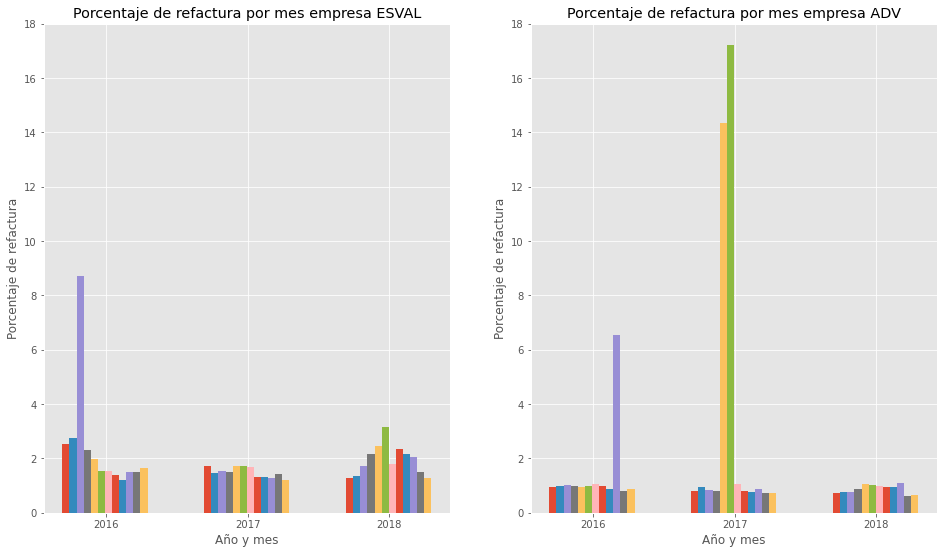

In [11]:
X = np.arange(3)
plt.subplot(1,2,1)
a = 0.05
for i in range(0, len(Data_FECHA_ESVAL)):
    plt.bar(X + a, Data_FECHA_ESVAL[i], width = 0.05)
    a = a + 0.05
plt.ylim(0, 18)
plt.rcParams["figure.figsize"] = (20, 8)
plt.ylabel('Porcentaje de refactura')
plt.xlabel('Año y mes')
plt.title("Porcentaje de refactura por mes empresa ESVAL")
plt.xticks(X+0.33, ["2016","2017","2018"])

plt.subplot(1,2,2)
a = 0.05
for i in range(0, len(Data_FECHA_ADV)):
    plt.bar(X + a, Data_FECHA_ADV[i], width = 0.05)
    a = a + 0.05
plt.ylim(0, 18)
plt.ylabel('Porcentaje de refactura')
plt.xlabel('Año y mes')
plt.title("Porcentaje de refactura por mes empresa ADV")
plt.xticks(X+0.33, ["2016","2017","2018"])

 En las graficas se puede notar que existen valores atipicos en algunos meses de algunos años, estos valores podrian borrarse de la base de datos, ya que podria llevar al modelo a aprender de ejemplos que pueden no volver a ocurrir.
 
 Después de analizar distintas opciones para filtrar los datos atipicos mediante graficas dinamincas de Power BI se decidio ocupar las variables "RECORR1", "COD_OBS" y "CLAVE_TERRENO".
Para decidir se ocuparon las graficas dinamicas mostradas en las siguiente imagenes, con esto se idearon los filtros en el codigo posterior.

##### **Filtrado casos atipicos 03-2016 de empresa ESVAL**

![title](img/03-2016_ESVAL.png)



##### **Filtrado casos atipicos 10-2016 de empresa ADV**

![title](img/10-2016_ADV.png)


##### **Filtrado casos atipicos 05-2017 de empresa ADV**

![title](img/05-2017_ADV.png)


#### **Filtrado casos atipicos 06-2017 de empresa ADV**

![title](img/06-2017_ADV.png)


#### **Filtrado casos atipicos 06-2018 de empresa ESVAL**

![title](img/06-2018_ADV.png)



A continuación se programaran los filtros obtenidos con el analisis fino de las graficas antes mostradas.

In [4]:
largo_data = len(Data)
#Filtrado casos atipicos 03-2016 LISTO
Data = Data.drop(Data[((Data['MES']=='3') & (Data['ANNO']=='2016') & (Data['COD_EMPRESA']=='1') & (Data['TIENE_REFA']==1)) &
                      ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='DXS') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CXS') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS') | (Data['COD_OBS']=='BYP')) &
                      ((Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='R'))
                     ].index)

#Filtrado casos atipicos 10-2016 LISTO
Data = Data.drop(Data[((Data['MES']=='10') & (Data['ANNO']=='2016') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
                      ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CVE')) &
                      (Data['CLAVE_TERRENO']=='N')].index)

#Filtrado casos atipicos 05-2017 LISTO
Data = Data.drop(Data[((Data['MES']=='5') & (Data['ANNO']=='2017') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
                      ((Data['RECORR1']=='08')|(Data['RECORR1']=='07')|(Data['RECORR1']=='06')|(Data['RECORR1']=='05')|
                       (Data['RECORR1']=='04')|(Data['RECORR1']=='03')|(Data['RECORR1']=='02')|(Data['RECORR1']=='01')) &
                      ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CC') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CVE') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS') | (Data['COD_OBS']=='CVA')) &
                      ((Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='2') | (Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='8') | (Data['CLAVE_TERRENO']=='I') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='P'))].index)
                      
#Filtrado casos atipicos 06-2017
Data = Data.drop(Data[((Data['MES']=='6') & (Data['ANNO']=='2017') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
                      ((Data['RECORR1']=='09')|(Data['RECORR1']=='10')|(Data['RECORR1']=='11')|(Data['RECORR1']=='12')|
                      (Data['RECORR1']=='13')|(Data['RECORR1']=='14')|(Data['RECORR1']=='15')|(Data['RECORR1']=='16')|
                      (Data['RECORR1']=='17')|(Data['RECORR1']=='18')|(Data['RECORR1']=='19')|(Data['RECORR1']=='20')) &
                      ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CC') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CVE') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS') | (Data['COD_OBS']=='DPU') | (Data['COD_OBS']=='LDE')) &
                      ((Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='2') | (Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='8') | (Data['CLAVE_TERRENO']=='3') | (Data['CLAVE_TERRENO']=='I') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='P') | (Data['CLAVE_TERRENO']=='T'))].index)

#Filtrado casos atipicos 06-2018 LISTO
Data = Data.drop(Data[((Data['MES']=='6') & (Data['ANNO']=='2018') & (Data['COD_EMPRESA']=='1') & (Data['TIENE_REFA']==1)) &
                      (Data['COD_OBS']=='CC') &
                      ((Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='2'))].index)

#Reordenar los indicides de dataframe
Data = Data.reset_index(drop=True)
N_filtrados = largo_data - len(Data)
print('los datos filtrados fueron: ',N_filtrados)

### 5. Detectar correlaciones entre columnas

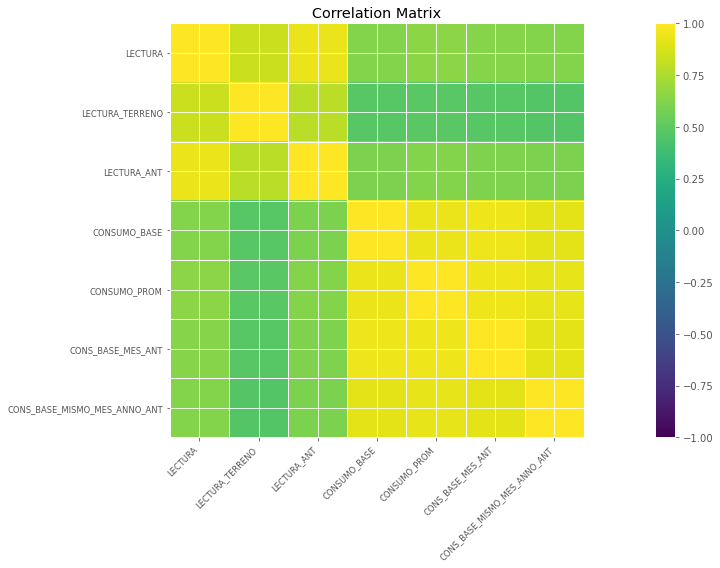

<Figure size 1440x576 with 0 Axes>

In [13]:
#Matriz de correlación
drop_elements = ['TIENE_REFA']
corr = Data.drop(drop_elements, axis = 1).set_index('NRO_SUMINISTRO').corr()
colormap = plt.cm.viridis
sm.graphics.plot_corr(corr, xnames=list(corr.columns), cmap=colormap, normcolor=True)
plt.show()
plt.savefig("matriz de correlaciones.jpg",)

 Analizando la matriz de correlaciones se puede notar que existe poca correlación entre las variables a excepción de algunas puntuales. Estas excepciones son "LECUTRA" con "LECTURA_ANT" y "LECTURA_TERRENO"; "CLAVE_TERRENO_MES_ANT" con "CONS_BASE_MES_ANT"; además existe una fuerte corelación entre "CONSUMO_BASE" y "CONSUMO_PROM". 
 
 Entendiendo los datos se puede inferir que estas correlaciones son esperables, ya que corresponden a lecturas en distintas instancias o en distinto instante de tiempo, pero del mismo cliente.

### 6. Grafica de algunas columnas para tener una idea de las relaciones.

Se haran graficas generales de distintas columnas para ver la relacion que tienen entre ellas y las etiquetas.

In [ ]:
#Separar datos con datos filtrados
Data = Datos()
Data_ESVAL = Data[Data['COD_EMPRESA'] == '1']
Data_ADV = Data[Data['COD_EMPRESA'] == '2']
del Data

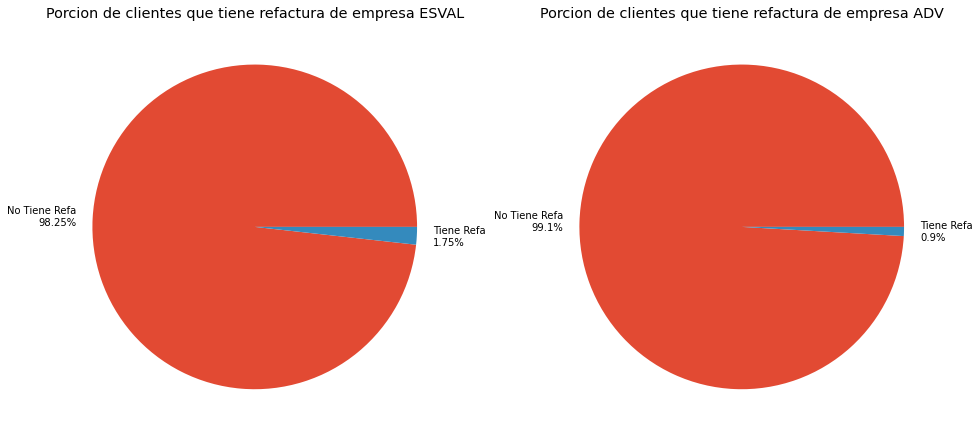

In [3]:
# Grafico de rosca del porcentaje
# Agrupando
tiene_refa_ESVAL = Data_ESVAL.groupby('TIENE_REFA').TIENE_REFA.count() 
# Creando las leyendas del grafico.
labels = [ 'Tiene Refa\n' + str(round(x * 1.0 / tiene_refa_ESVAL.sum() * 100.0, 2)) + '%'  for x in tiene_refa_ESVAL ]
labels[0] = 'No ' + labels[0]

plt.subplot(1, 2, 1)
plt.pie(tiene_refa_ESVAL, labels=labels)
plt.title('Porcion de clientes que tiene refactura de empresa ESVAL')

# Agrupando
tiene_refa_ADV = Data_ADV.groupby('TIENE_REFA').TIENE_REFA.count() 
# Creando las leyendas del grafico.
labels = [ 'Tiene Refa\n' + str(round(x * 1.0 / tiene_refa_ADV.sum() * 100.0, 2)) + '%'  for x in tiene_refa_ADV ]
labels[0] = 'No ' + labels[0]

plt.subplot(1, 2, 2)
plt.pie(tiene_refa_ADV, labels=labels)
plt.title('Porcion de clientes que tiene refactura de empresa ADV')

plt.show()

Se nota de la grafica que hay muy poco registros con refacturas, es decir la base de datos esta desbalanceada. Esto conlleva una tendencia de overffiting de los modelos y es algo a tener muy en cuenta a la hora de diseñarlos. Este comportamiento se nota con mayor enfasis en la empresa ADV (luego de filtrar los valores atipicos)

#### Análisis del mes y el año

In [16]:
Data_FECHA_ESVAL = np.zeros((12, 3))
Data_FECHA_ADV = np.zeros((12, 3))
for i in range(1,13):
    for j in range(2016,2019):
        Data_FECHA_ESVAL[i-1,j-2016] = (Data_ESVAL[(Data_ESVAL['TIENE_REFA']==1) & (Data_ESVAL['MES']==str(i)) & (Data_ESVAL['ANNO']==str(j))].TIENE_REFA.count()
                         /Data_ESVAL[(Data_ESVAL['MES']==str(i)) & (Data_ESVAL['ANNO']==str(j))].TIENE_REFA.count())*100
        
        Data_FECHA_ADV[i-1,j-2016] = (Data_ADV[(Data_ADV['TIENE_REFA']==1) & (Data_ADV['MES']==str(i)) & (Data_ADV['ANNO']==str(j))].TIENE_REFA.count()
                         /Data_ADV[(Data_ADV['MES']==str(i)) & (Data_ADV['ANNO']==str(j))].TIENE_REFA.count())*100

([<matplotlib.axis.XTick at 0x22a15479cc8>,
 [Text(0.33, 0, '2016'), Text(1.33, 0, '2017'), Text(2.33, 0, '2018')])

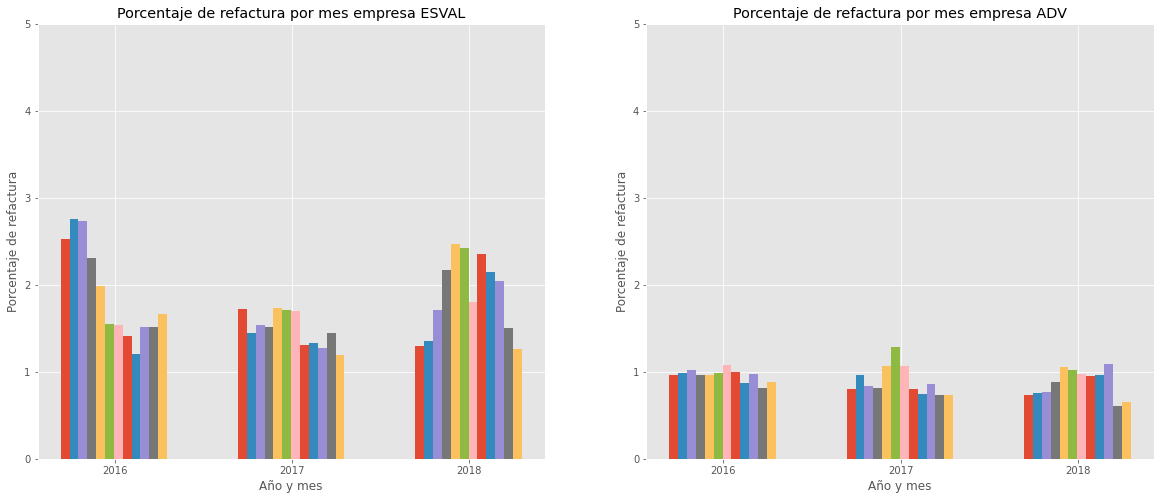

In [74]:
X = np.arange(3)
plt.subplot(1,2,1)
a = 0.05
for i in range(0, len(Data_FECHA_ESVAL)):
    plt.bar(X + a, Data_FECHA_ESVAL[i], width = 0.05)
    a = a + 0.05
plt.ylim(0, 5)
plt.rcParams["figure.figsize"] = (20, 8)
plt.ylabel('Porcentaje de refactura')
plt.xlabel('Año y mes')
plt.title("Porcentaje de refactura por mes empresa ESVAL")
plt.xticks(X+0.33, ["2016","2017","2018"])

plt.subplot(1,2,2)
a = 0.05
for i in range(0, len(Data_FECHA_ADV)):
    plt.bar(X + a, Data_FECHA_ADV[i], width = 0.05)
    a = a + 0.05
plt.ylim(0, 5)
plt.ylabel('Porcentaje de refactura')
plt.xlabel('Año y mes')
plt.title("Porcentaje de refactura por mes empresa ADV")
plt.xticks(X+0.33, ["2016","2017","2018"])

Se nota que entre años el comportamiento de las refacturas para la empresa ADV es similar, mietras que para ESVAL tiene cambios en su comportamiento.

###### Análisis solo por meses

In [70]:
Data_MES_ESVAL = np.zeros((12))
Data_MES_ADV = np.zeros((12))
j = 0
lista_mes = ['1','2','3','4','5','6','7','8','9','10','11','12']
for i in lista_mes:
    Data_MES_ESVAL[j] = (Data_ESVAL[(Data_ESVAL['TIENE_REFA']==1) & (Data_ESVAL['MES']==str(i))].TIENE_REFA.count()
                                    /Data_ESVAL[(Data_ESVAL['MES']==str(i))].TIENE_REFA.count())*100
    
    Data_MES_ADV[j] = (Data_ADV[(Data_ADV['TIENE_REFA']==1) & (Data_ADV['MES']==str(i))].TIENE_REFA.count()
                                  /Data_ADV[(Data_ADV['MES']==str(i))].TIENE_REFA.count())*100
    j = j + 1

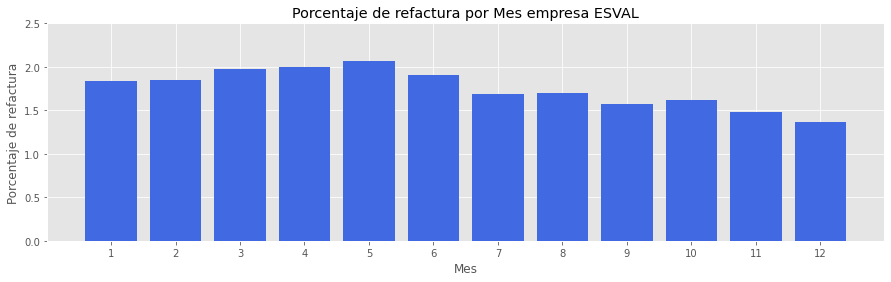

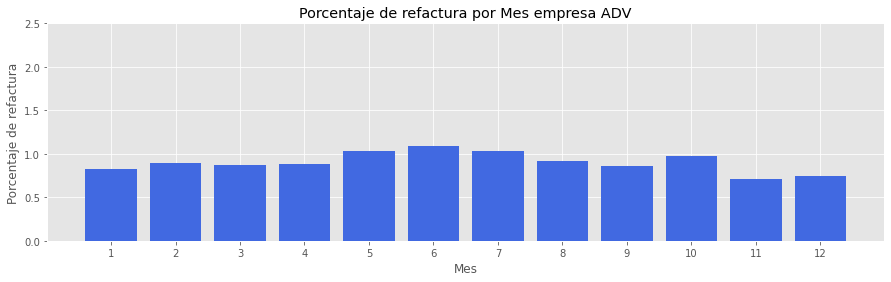

In [76]:
tricks = ['1','2','3','4','5','6','7','8','9','10','11','12']
fig, ax = plt.subplots()
ax.bar(list(range(0,len(Data_MES_ESVAL))), Data_MES_ESVAL, align='center', color='RoyalBlue')
ax.set_ylabel('Porcentaje de refactura')
ax.set_xlabel('Mes')
ax.set_title("Porcentaje de refactura por Mes empresa ESVAL")
fig.set_size_inches(15,4)
ax.set_xticks(range(12))
ax.set_ylim(0,2.5)
ax.set_xticklabels(tricks)
plt.show()

fig, ax = plt.subplots()
ax.bar(list(range(0,len(Data_MES_ADV))), Data_MES_ADV, align='center', color='RoyalBlue')
ax.set_ylabel('Porcentaje de refactura')
ax.set_xlabel('Mes')
ax.set_title("Porcentaje de refactura por Mes empresa ADV")
fig.set_size_inches(15,4)
ax.set_xticks(range(12))
ax.set_ylim(0,2.5)
ax.set_xticklabels(tricks)
plt.show()

Se nota que la empresa ADV tiene menor porcentaje de refacturas que la empresa ESVAL. Tambien, se puede ver que la cantidad de refacturas disminuye levemente a medida que avanza el año.

###### Análisis de consumos 

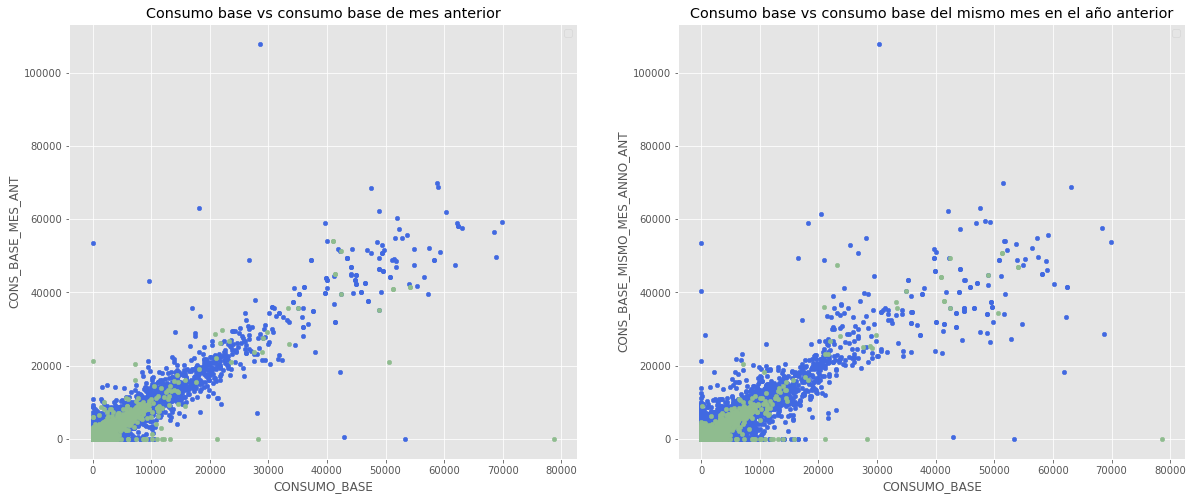

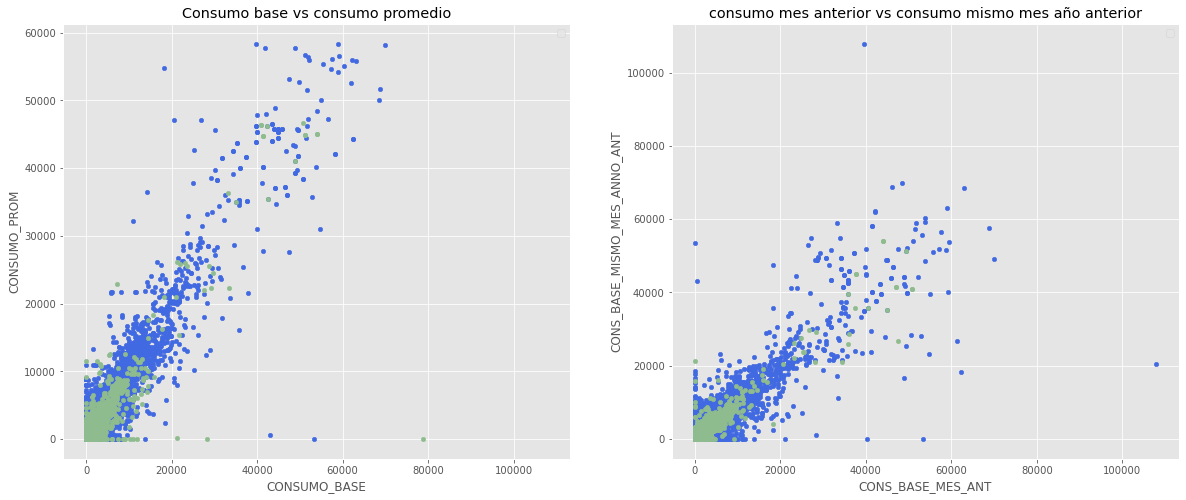

In [20]:
#graficas
colors = {0: 'RoyalBlue', 1: 'DarkSeaGreen'}
tiene_refa_colors = Data.TIENE_REFA.map(colors)
fig, ax = plt.subplots(1,2, sharex=True)

ax[0].set_ylabel('CONS_BASE_MES_ANT')
ax[0].set_xlabel('CONSUMO_BASE')
ax[0].set_title("Consumo base vs consumo base de mes anterior")
ax[0].legend(['No tiene refactura', 'Tiene refactura'])
for TIENE_REFA in set(Data.TIENE_REFA):
    ax[0].scatter(
        Data.CONSUMO_BASE[Data.TIENE_REFA == TIENE_REFA],
        Data.CONS_BASE_MES_ANT[Data.TIENE_REFA == TIENE_REFA],
        s = 20,
        c = colors[TIENE_REFA],
        label = TIENE_REFA)

ax[1].set_ylabel('CONS_BASE_MISMO_MES_ANNO_ANT')
ax[1].set_xlabel('CONSUMO_BASE')
ax[1].set_title("Consumo base vs consumo base del mismo mes en el año anterior")
ax[1].legend(['No tiene refactura', 'Tiene refactura'])
for TIENE_REFA in set(Data.TIENE_REFA):
    ax[1].scatter(
        Data.CONSUMO_BASE[Data.TIENE_REFA == TIENE_REFA],
        Data.CONS_BASE_MISMO_MES_ANNO_ANT[Data.TIENE_REFA == TIENE_REFA],
        s = 20,
        c = colors[TIENE_REFA],
        label = TIENE_REFA)
plt.show()
    
fig, ax = plt.subplots(1,2, sharex=True)
ax[0].set_ylabel('CONSUMO_PROM')
ax[0].set_xlabel('CONSUMO_BASE')
ax[0].set_title("Consumo base vs consumo promedio")
ax[0].legend(['No tiene refactura', 'Tiene refactura'])
for TIENE_REFA in set(Data.TIENE_REFA):
    ax[0].scatter(
        Data.CONSUMO_BASE[Data.TIENE_REFA == TIENE_REFA],
        Data.CONSUMO_PROM[Data.TIENE_REFA == TIENE_REFA],
        s = 20,
        c = colors[TIENE_REFA],
        label = TIENE_REFA)
    
ax[1].set_ylabel('CONS_BASE_MISMO_MES_ANNO_ANT')
ax[1].set_xlabel('CONS_BASE_MES_ANT')
ax[1].set_title("consumo mes anterior vs consumo mismo mes año anterior")
ax[1].legend(['No tiene refactura', 'Tiene refactura'])
for TIENE_REFA in set(Data.TIENE_REFA):
    ax[1].scatter(
        Data.CONS_BASE_MISMO_MES_ANNO_ANT[Data.TIENE_REFA == TIENE_REFA],
        Data.CONS_BASE_MES_ANT[Data.TIENE_REFA == TIENE_REFA],
        s = 20,
        c = colors[TIENE_REFA],
        label = TIENE_REFA)
plt.show()

 En las graficas se nota que el comportamiento de las lecturas es bastante lineal, pero que no hay una separacion clara entre etiquetas.
 
 Por otro lado el comportamiento de los consumos contrastador podria ser lineal, pero mucho mas disperso y tampoco hay un separacion clara entre etiquetas. Aun que se puede ver que la mayor cantidad de refacturas se producen cuando los consumos son bajos.

###### Análisis lecturas

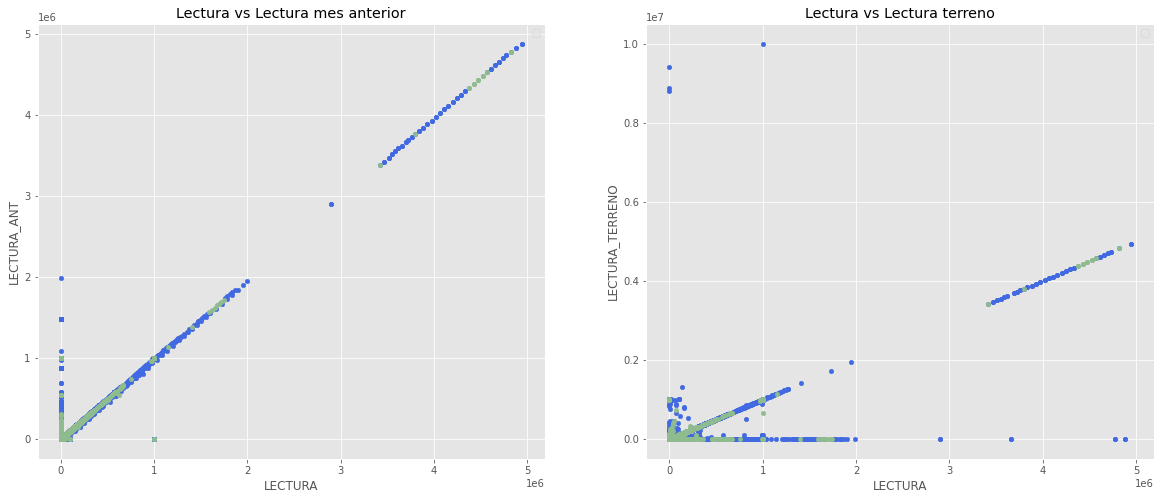

In [21]:
colors = {0: 'RoyalBlue', 1: 'DarkSeaGreen'}
tiene_refa_colors = Data.TIENE_REFA.map(colors)
fig, ax = plt.subplots(1,2)

ax[0].set_ylabel('LECTURA_ANT')
ax[0].set_xlabel('LECTURA')
ax[0].set_title("Lectura vs Lectura mes anterior")
ax[0].legend(['No tiene refactura', 'Tiene refactura'])
for TIENE_REFA in set(Data.TIENE_REFA):
    ax[0].scatter(
        Data.LECTURA[Data.TIENE_REFA == TIENE_REFA],
        Data.LECTURA_ANT[Data.TIENE_REFA == TIENE_REFA],
        s = 20,
        c = colors[TIENE_REFA],
        label = TIENE_REFA)
    
ax[1].set_ylabel('LECTURA_TERRENO')
ax[1].set_xlabel('LECTURA')
ax[1].set_title("Lectura vs Lectura terreno")
ax[1].legend(['No tiene refactura', 'Tiene refactura'])
for TIENE_REFA in set(Data.TIENE_REFA):
    ax[1].scatter(
        Data.LECTURA[Data.TIENE_REFA == TIENE_REFA],
        Data.LECTURA_TERRENO[Data.TIENE_REFA == TIENE_REFA],
        s = 20,
        c = colors[TIENE_REFA],
        label = TIENE_REFA)

plt.show()

Se nota que hay un comportamiento bastante lineal en las graficas. Existen varios registros con valor "0" que significan que no hay lectura, pero vemos que esto no incide en la cantidad proporcional de refacturas que ocurren.

###### Analisis sector de  facturación

In [2]:
#Separar datos segun empresa
Data_ESVAL = Data[Data['COD_EMPRESA'] == '1']
Data_ADV = Data[Data['COD_EMPRESA'] == '2']

In [3]:
RE1 = len(set(Data['RECORR1']))
Data_RE1_ESVAL = np.zeros(RE1)
Data_RE1_ADV = np.zeros(RE1)
lista_RE1 = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20']
for i in lista_RE1:
    if Data_ESVAL[(Data_ESVAL['RECORR1']==i)].TIENE_REFA.count() > 0:
        Data_RE1_ESVAL[int(i)-1] = (Data_ESVAL[(Data_ESVAL['TIENE_REFA']==1) & (Data_ESVAL['RECORR1']==i)].TIENE_REFA.count()
                                    /Data_ESVAL[(Data_ESVAL['RECORR1']==i)].TIENE_REFA.count())*100
    else: Data_RE1_ESVAL[int(i)-1] = 0
    if Data_ADV[(Data_ADV['RECORR1']==i)].TIENE_REFA.count() > 0:
        Data_RE1_ADV[int(i)-1] = (Data_ADV[(Data_ADV['TIENE_REFA']==1) & (Data_ADV['RECORR1']==i)].TIENE_REFA.count()
                                  /Data_ADV[(Data_ADV['RECORR1']==i)].TIENE_REFA.count())*100
    else: Data_RE1_ADV[int(i)-1] = 0

In [4]:
Data_RE1_ESVAL

array([1.53780243, 1.66706895, 1.7864294 , 1.72939229, 1.95076072,
       1.90853536, 2.11998271, 1.68360665, 2.21247426, 1.86833699,
       2.60073514, 2.43877089, 1.94946432, 1.78696393, 2.50234643,
       2.14190035, 1.99172999, 1.49709082, 1.62725666, 1.33111042])

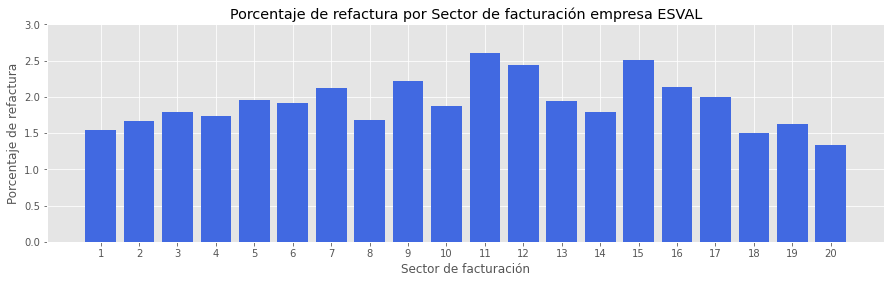

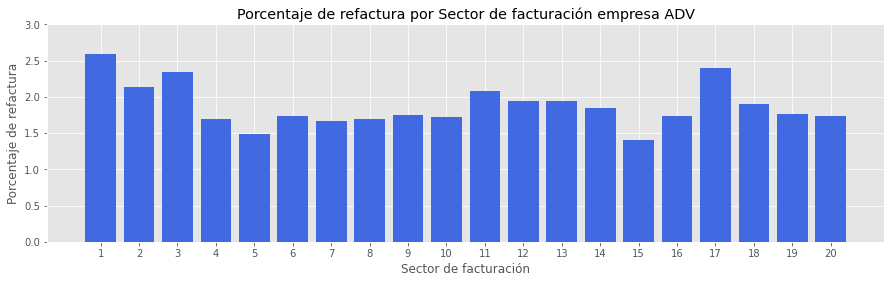

In [5]:
tricks = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
fig, ax = plt.subplots()
ax.bar(list(range(0,len(Data_RE1_ESVAL))), Data_RE1_ESVAL, align='center', color='RoyalBlue')
ax.set_ylabel('Porcentaje de refactura')
ax.set_xlabel('Sector de facturación')
ax.set_title("Porcentaje de refactura por Sector de facturación empresa ESVAL")
fig.set_size_inches(15,4)
ax.set_xticks(range(20))
ax.set_ylim(0,3)
ax.set_xticklabels(tricks)
plt.show()

fig, ax = plt.subplots()
ax.bar(list(range(0,len(Data_RE1_ADV))), Data_RE1_ADV, align='center', color='RoyalBlue')
ax.set_ylabel('Porcentaje de refactura')
ax.set_xlabel('Sector de facturación')
ax.set_title("Porcentaje de refactura por Sector de facturación empresa ADV")
fig.set_size_inches(15,4)
ax.set_xticks(range(20))
ax.set_ylim(0,3)
ax.set_xticklabels(tricks)
plt.show()

Se nota de las graficas que la empresa ADV tiene menor porcentaje de refacturas que la empresa ESVAL. Tambien, que el porcentaje de refacturas es bastante disparejo entre localidades, pero no excesivamente.

###### Análisis por categoria de cliente

In [66]:
CAT = len(set(Data['CATEGORIA']))
Data_CAT_ESVAL = np.zeros(CAT)
Data_CAT_ADV = np.zeros(CAT)
j=0
lista_cat = ['C', 'F', 'I', 'R']
for i in lista_cat:
    if Data_ESVAL[(Data_ESVAL['CATEGORIA']==i)].TIENE_REFA.count() > 0:
        Data_CAT_ESVAL[j] = (Data_ESVAL[(Data_ESVAL['TIENE_REFA']==1) & (Data_ESVAL['CATEGORIA']==i)].TIENE_REFA.count()
                                  /Data_ESVAL[(Data_ESVAL['CATEGORIA']==i)].TIENE_REFA.count())*100
    else: Data_CAT_ESVAL[j] = 0
    if Data_ADV[(Data_ADV['CATEGORIA']==i)].TIENE_REFA.count() > 0:
        Data_CAT_ADV[j] = (Data_ADV[(Data_ADV['TIENE_REFA']==1) & (Data_ADV['CATEGORIA']==i)].TIENE_REFA.count()
                                /Data_ADV[(Data_ADV['CATEGORIA']==i)].TIENE_REFA.count())*100
    else: Data_CAT_ADV[j] = 0
    j=j+1

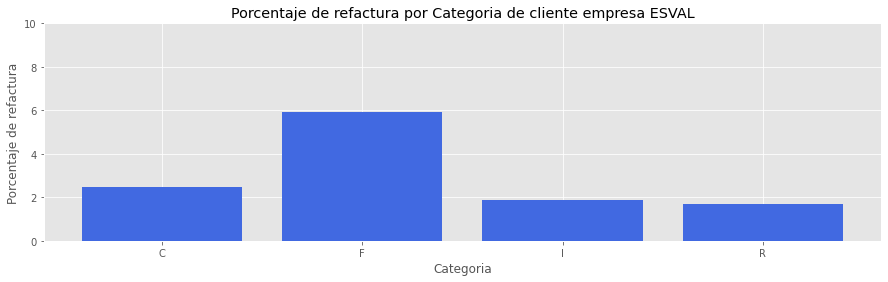

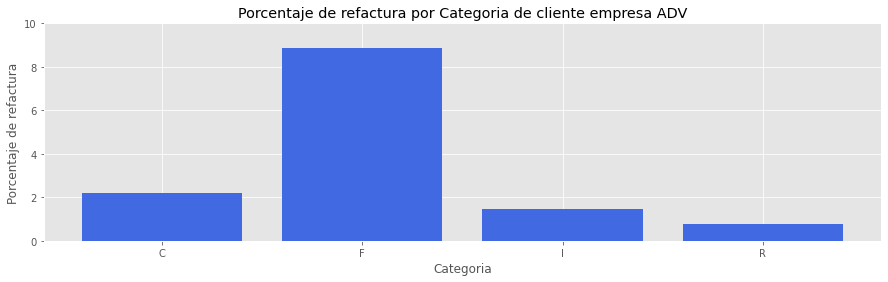

In [79]:
tricks = ['C', 'F', 'I', 'R']
fig, ax = plt.subplots()
ax.bar(list(range(0,len(Data_CAT_ESVAL))), Data_CAT_ESVAL, align='center', color='RoyalBlue')
ax.set_ylabel('Porcentaje de refactura')
ax.set_xlabel('Categoria')
ax.set_title("Porcentaje de refactura por Categoria de cliente empresa ESVAL")
fig.set_size_inches(15,4)
ax.set_xticks(range(4))
ax.set_ylim(0,10)
ax.set_xticklabels(tricks)
plt.show()

fig, ax = plt.subplots()
ax.bar(list(range(0,len(Data_CAT_ADV))), Data_CAT_ADV, align='center', color='RoyalBlue')
ax.set_ylabel('Porcentaje de refactura')
ax.set_xlabel('Categoria')
ax.set_title("Porcentaje de refactura por Categoria de cliente empresa ADV")
fig.set_size_inches(15,4)
ax.set_xticks(range(4))
ax.set_ylim(0,10)
ax.set_xticklabels(tricks)
plt.show()

Se nota que el major porcentaje de refacturas de las dos empresas esta asociado a la categoria "F" de cliente.

###### Análisis por codigo de diametro

In [61]:
CAT = len(set(Data['COD_DIAMETRO']))
Data_DIA_ESVAL = np.zeros(CAT)
Data_DIA_ADV = np.zeros(CAT)
j=0
lista_dia = ['013', '019', '025', '032', '038', '050', '075', '100', '150', '200']
for i in lista_dia:
    if Data_ESVAL[(Data_ESVAL['COD_DIAMETRO']==i)].TIENE_REFA.count() > 0:
        Data_DIA_ESVAL[j] = (Data_ESVAL[(Data_ESVAL['TIENE_REFA']==1) & (Data_ESVAL['COD_DIAMETRO']==i)].TIENE_REFA.count()
                                  /Data_ESVAL[(Data_ESVAL['COD_DIAMETRO']==i)].TIENE_REFA.count())*100
    else: Data_DIA_ESVAL[j] = 0
    if Data_ADV[(Data_ADV['COD_DIAMETRO']==i)].TIENE_REFA.count() > 0:
        Data_DIA_ADV[j] = (Data_ADV[(Data_ADV['TIENE_REFA']==1) & (Data_ADV['COD_DIAMETRO']==i)].TIENE_REFA.count()
                                /Data_ADV[(Data_ADV['COD_DIAMETRO']==i)].TIENE_REFA.count())*100
    else: Data_DIA_ADV[j] = 0
    j=j+1

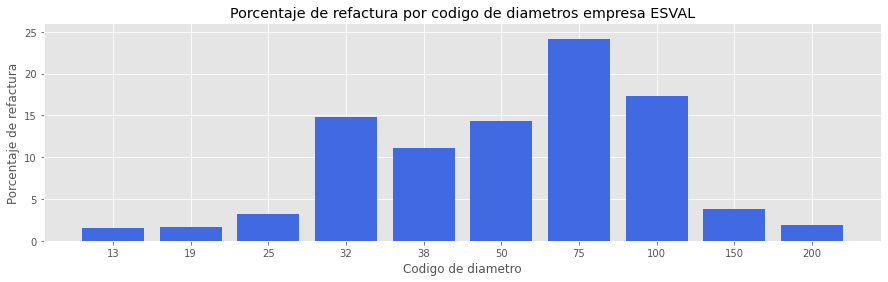

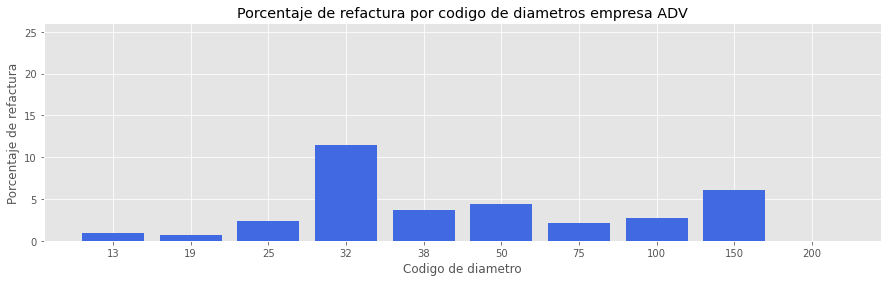

In [84]:
tricks = ['13', '19', '25', '32', '38', '50', '75', '100', '150', '200']
fig, ax = plt.subplots()
ax.bar(list(range(0,len(Data_DIA_ESVAL))), Data_DIA_ESVAL, align='center', color='RoyalBlue')
ax.set_ylabel('Porcentaje de refactura')
ax.set_xlabel('Codigo de diametro')
ax.set_title("Porcentaje de refactura por codigo de diametros empresa ESVAL")
fig.set_size_inches(15,4)
ax.set_xticks(range(10))
ax.set_ylim(0,26)
ax.set_xticklabels(tricks)
plt.show()

fig, ax = plt.subplots()
ax.bar(list(range(0,len(Data_DIA_ADV))), Data_DIA_ADV, align='center', color='RoyalBlue')
ax.set_ylabel('Porcentaje de refactura')
ax.set_xlabel('Codigo de diametro')
ax.set_title("Porcentaje de refactura por codigo de diametros empresa ADV")
fig.set_size_inches(15,4)
ax.set_xticks(range(10))
ax.set_ylim(0,26)
ax.set_xticklabels(tricks)
plt.show()

Se nota que en la empresa ESVAL el mayor porcentaje de refacturas ocurre en los clientes con codigo de diametro "75", seguido por "100", "32", "50", "38".
Mientras que en la empresa ADV el mayor porcentaje de refacturas ocurre en los clientes con codigo de diametro "32", seguido por "150" y "50".

#### Análisis por remarcador

In [64]:
REM = len(set(Data['TIE_REMAR']))
Data_REM_ESVAL = np.zeros(REM)
Data_REM_ADV = np.zeros(REM)
j=0
lista_rem = ['M', 'N', 'R', 'S']
for i in lista_rem:
    if Data_ESVAL[(Data_ESVAL['TIE_REMAR']==i)].TIENE_REFA.count() > 0:
        Data_REM_ESVAL[j] = (Data_ESVAL[(Data_ESVAL['TIENE_REFA']==1) & (Data_ESVAL['TIE_REMAR']==i)].TIENE_REFA.count()
                             /Data_ESVAL[(Data_ESVAL['TIE_REMAR']==i)].TIENE_REFA.count())*100
    else: 
        Data_REM_ESVAL[j] = 0
        
    if Data_ADV[(Data_ADV['TIE_REMAR']==i)].TIENE_REFA.count() > 0:
        Data_REM_ADV[j] = (Data_ADV[(Data_ADV['TIENE_REFA']==1) & (Data_ADV['TIE_REMAR']==i)].TIENE_REFA.count()
                           /Data_ADV[(Data_ADV['TIE_REMAR']==i)].TIENE_REFA.count())*100
    else: 
        Data_REM_ADV[j] = 0
        
    j=j+1

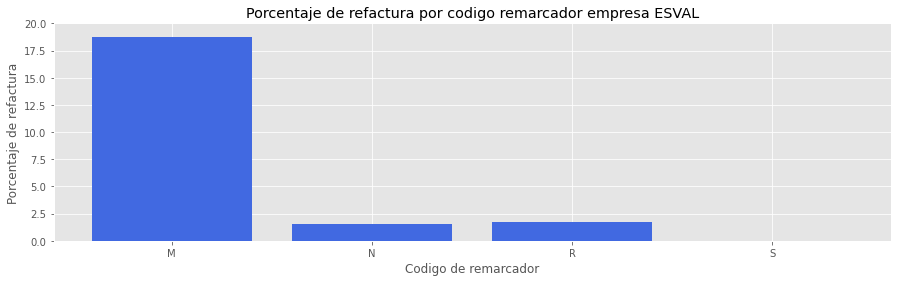

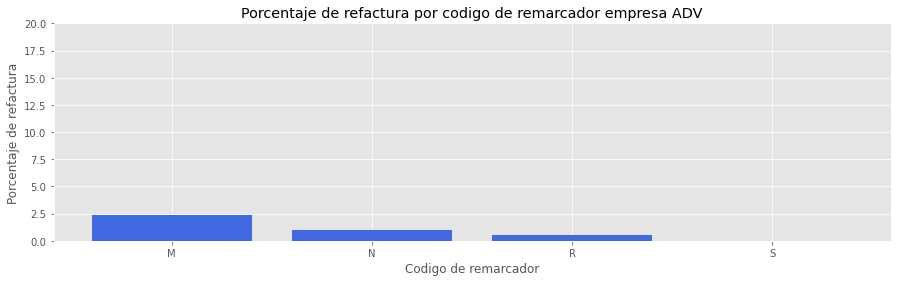

In [83]:
tricks = ['M', 'N', 'R', 'S']
fig, ax = plt.subplots()
ax.bar(list(range(0,len(Data_REM_ESVAL))), Data_REM_ESVAL, align='center', color='RoyalBlue')
ax.set_ylabel('Porcentaje de refactura')
ax.set_xlabel('Codigo de remarcador')
ax.set_title("Porcentaje de refactura por codigo remarcador empresa ESVAL")
fig.set_size_inches(15,4)
ax.set_xticks(range(4))
ax.set_ylim(0,20)
ax.set_xticklabels(tricks)
plt.show()

fig, ax = plt.subplots()
ax.bar(list(range(0,len(Data_REM_ADV))), Data_REM_ADV, align='center', color='RoyalBlue')
ax.set_ylabel('Porcentaje de refactura')
ax.set_xlabel('Codigo de remarcador')
ax.set_title("Porcentaje de refactura por codigo de remarcador empresa ADV")
fig.set_size_inches(15,4)
ax.set_xticks(range(4))
ax.set_ylim(0,20)
ax.set_xticklabels(tricks)
plt.show()

Se nota que el mayor porcentaje de refacturas ocurre cuando el cliente tiene codigo de remarcador "M" en las dos empresas, aunque en la empresa ESVAL es mucho mas notoria esta mayoria.

### 7. Árbol de decisión y análisis PCA (Principal Component Analysis).
Se hizo un arbol de desición para tener una idea de la impotancia de las variables. Luego, se hizo un analisis PCA para ver como se comportan los datos a una reducción de dimensionalidad.

###### Árbol de decisión

Se Cargo base de datos
Splits listos


C:\Users\joaqu\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (6653283, 417)
Dimensiones etiquetas:  (6653283,)
Se empieza a entrenar el arbol
Se entreno el arbol


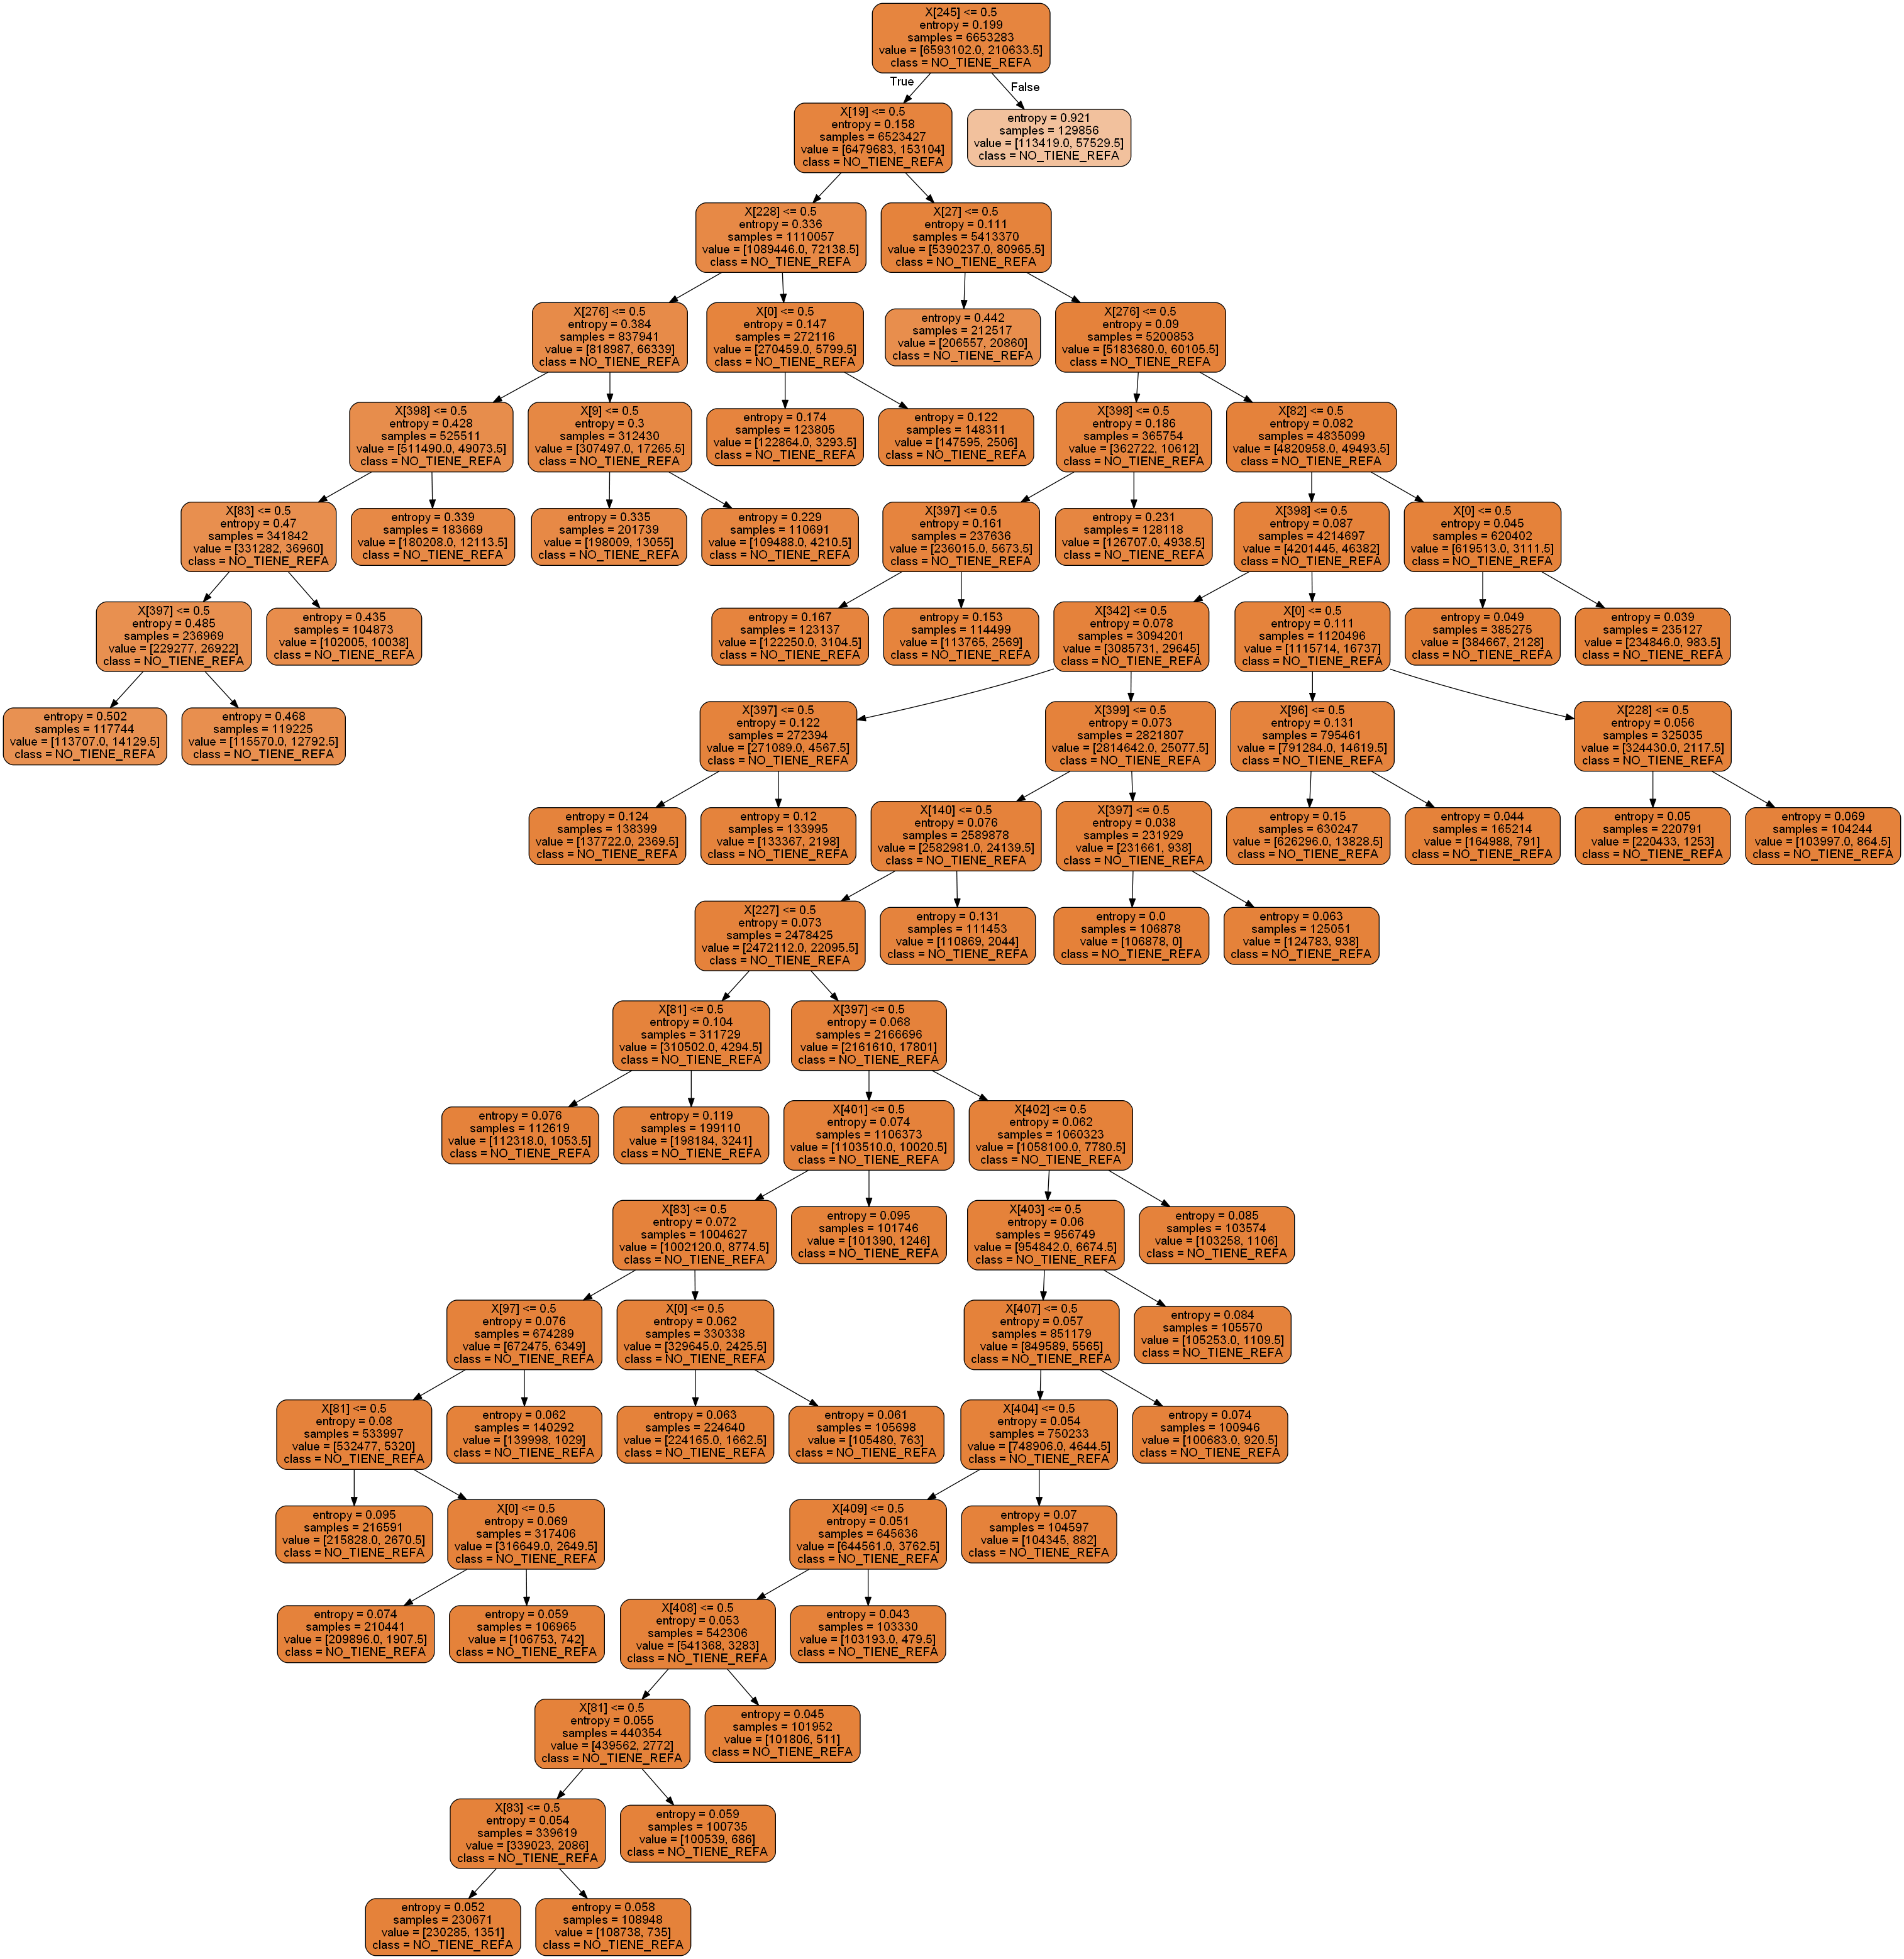

In [2]:
#Cargar datos
Data = Datos()
Data = Data.drop('NRO_SUMINISTRO', axis=1)
Data = Data.drop('COD_LECTOR', axis=1)
Data = Data.drop(Data[Data['COD_EMPRESA']!='2'].index)
Data = Data.drop('COD_EMPRESA', axis=1)


#guardar columnas que sean float
columnas = Data.columns
col = np.zeros(len(Data.columns))
j = 0
for i in columnas:
    if Data[i].dtype == 'f':
        col[j] = 1
    j = j + 1

Dataset = Data.values
del Data

x = Dataset[:, :-1]
y = Dataset[:,-1]
del Dataset
x = x.astype(str)
y = y.reshape((len (y), 1))

#Splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,train_size=0.8)
del x
del y
print('Splits listos')

#-----------------------------------------------------------------------------------------------------------------------------
#Preparar datos para codificacion
x_train = np.transpose(x_train)
x_test = np.transpose(x_test)

#Separar datos numericos de categoricos
init = 0
k = 0
for i in range(0, len(col)-1):
    if col[i] == 1:
        if init == 2:
            x_train_num = np.append(x_train_num, [x_train[k]], axis=0)
            x_train = np.delete(x_train, k, axis=0)
            x_test_num = np.append(x_test_num, [x_test[k]], axis=0)
            x_test = np.delete(x_test, k, axis=0)
            k = k - 1
        if init == 1:
            x_train_num = np.append([x_train_num], [x_train[k]], axis=0)
            x_train = np.delete(x_train, k, axis=0)
            x_test_num = np.append([x_test_num], [x_test[k]], axis=0)
            x_test = np.delete(x_test, k, axis=0)
            k = k - 1
            init = 2
        if init == 0:
            x_train_num = x_train[k]
            x_train = np.delete(x_train, k, axis=0)
            x_test_num = x_test[k]
            x_test = np.delete(x_test, k, axis=0)
            k = k - 1
            init = 1
        k = k + 1
    else:
        k = k + 1

x_train = np.transpose(x_train)
x_test = np.transpose(x_test)

#codificacion OneHot para datos categorios
ohe = OneHotEncoder(dtype='uint16',handle_unknown='error',drop='first')
ohe.fit(x_train)
x_train = ohe.transform(x_train)
x_test = ohe.transform(x_test)

#standar scaler para datos numericos
x_train_num = np.transpose(x_train_num)
x_test_num = np.transpose(x_test_num)
standardscaler = StandardScaler()
x_train_num = standardscaler.fit_transform(x_train_num)
x_test_num = standardscaler.transform(x_test_num)
x_train_num = np.transpose(x_train_num)
x_test_num = np.transpose(x_test_num)

x_train = np.transpose(x_train)
x_train_num = x_train_num.astype(float)
x_train_num = x_train_num.astype(int)

x_test = np.transpose(x_test)
x_test_num = x_test_num.astype(float)
x_test_num = x_test_num.astype(int)

#volver a unir los datos
x_train = scipy.sparse.vstack((x_train, x_train_num))
del x_train_num
x_test = scipy.sparse.vstack((x_test, x_test_num))
del x_test_num

x_train = np.transpose(x_train)
x_test = np.transpose(x_test)

#codificar las etiquetas
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

print('Codificacion lista')
print('Dimensiones datos: ',x_train.shape)
print('Dimensiones etiquetas: ',y_train.shape)
#----------------------------------------------------------------------------------------------------------------------------

# Crear Arbol de decision con profundidad = 15
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=100000,
                                            min_samples_leaf=100000,
                                            max_depth = 100,
                                            max_leaf_nodes = 200,
                                            class_weight={1:3.5})
print('Se empieza a entrenar el arbol')
decision_tree.fit(x_train, y_train)
print('Se entreno el arbol')

# exportar el modelo a archivo .dot
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 20,
                              impurity = True,
                              #feature_names = list(data.drop(['TIENE_REFA'], axis=1)),
                              #feature_names = list(data),
                              class_names = ['NO_TIENE_REFA', 'TIENE_REFA'],
                              rounded = True,
                              filled= True )
        
# Convertir el archivo .dot a png para poder visualizarlo
import pydot
(graph,) = pydot.graph_from_dot_file('tree1.dot')
graph.write_png('tree1.png')
PImage("tree1.png")

In [3]:
#Acurracy del arbol creado
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 4)
print("El accuracy de los datos de train es ",acc_decision_tree)
acc_decision_tree = round(decision_tree.score(x_test, y_test) * 100, 4)
print("El accuracy de los datos de validación es ",acc_decision_tree)

El accuracy de los datos de train es  99.0955
El accuracy de los datos de validación es  99.1037


Se codifico las variables categoricas de la base de datos con OneHotEncoder para representarlas de mejor manera. Se nota que el naranjo fuerte en cada nodo del árbol quiere decir que la mayoria de etiquetas en ese nodo es mayoritariamente 'NO TIENE REFA', lo anterior ocurre por la la base de datos altamente desbalanceada. 

En este caso se limito el número de hojas final del árbol, asi como su maxima profundidad. Es por esto, que se ocupan pocas variables de las 417 obtenidas con OneHotEncoder. 

Es bueno saber que pueden haber varios arboles de desición distintos con los mismo resultados. Se deberian hacer un algoritmo de busqueda amplio como **RANDOM FOREST** para tener una idea mas general de que variables tienen mayor importancia. Y luego pensar en eliminar alguna para hacer la base de datos mas manejable.

###### Analisis PCA (Principal Component Analysis)

In [29]:
Data = Datos()

Se Cargo base de datos


In [30]:
# Separating out the features
x = Data.iloc[:, 0:26].values
# Separating out the target
y = Data.iloc[:, -1].values
del Data
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
del x
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

Data = pd.DataFrame(data = y, columns = ['TIENE_REFA'])
del y

#Se unen los dato en un solo dataframe
final_data = pd.concat([principalDf, Data[['TIENE_REFA']]], axis = 1)
del principalDf
del Data

In [ ]:
#para probar con el x_Train del arbol
x_train = pd.DataFrame(data = x_train)

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_train)
del x_train
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

Data = pd.DataFrame(data = y_train, columns = ['TIENE_REFA'])
del y_train3

#Se unen los dato en un solo dataframe
final_data = pd.concat([principalDf, Data[['TIENE_REFA']]], axis = 1)
del principalDf
del Data

[0.66028843 0.14824761]
0.8085360376623665


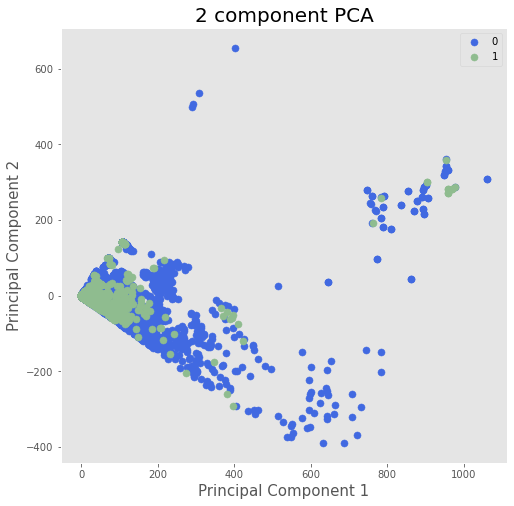

In [32]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['RoyalBlue', 'DarkSeaGreen']
for target, color in zip(targets,colors):
    indicesToKeep = final_data['TIENE_REFA'] == target
    ax.scatter(final_data.loc[indicesToKeep, 'principal component 1']
               , final_data.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 20)
ax.legend(targets)
ax.grid()

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

Según la gráfica obtenida del analisis PCA se nota que las variables tienen una separación claramente no lineal y que no se puede apreciar de buena manera en 2 dimensiones.

In [ ]:
PCA con 10 componentes principales
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(x)
del x
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

Data = pd.DataFrame(data = y, columns = ['TIENE_REFA'])
del y

Se unen los dato en un solo dataframe
final_data = pd.concat([principalDf, Data[['TIENE_REFA']]], axis = 1)

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

Se nota que con 10 dimensiones el modelo tiene una variación grande del 75,7%, esto se podria interpretar como que vale la pena tener mas dimensiones en nuestro modelo, por lo menos mas que 10. 

### Extra: Comparación de registros con refactura con y sin responsabilidad del analisista
Para este estudio se ocuparon los datos del sector 2 en marzo del 2018 de la empresa ESVAL.

Se tomaron los registros con "CLAVE_LECTURA" igual a "P", "A", "B", "C", "G", "M", "O", "W", "Z" como los registros que tienen responsabilidad del analista, ya que cuando existen significa que hubo un cambio en el consumo. 

Se Cargo base de datos


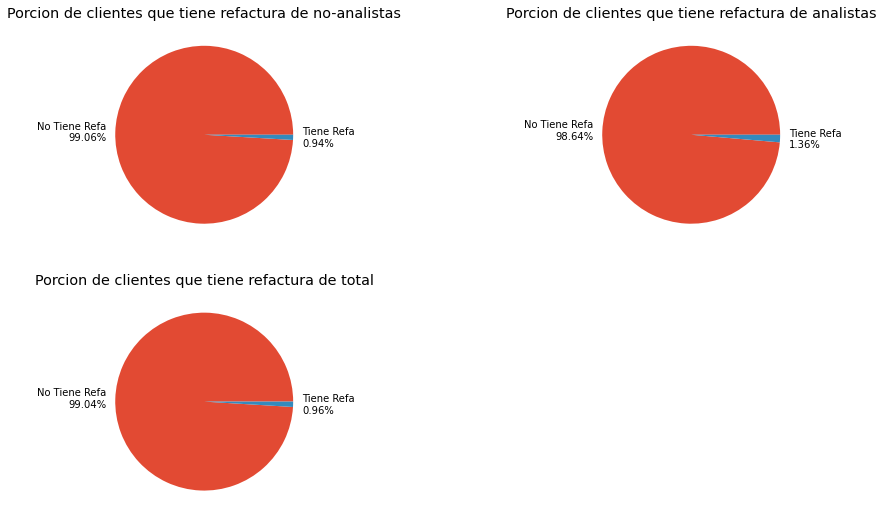

In [2]:
Data = Datos()
Data = Data.drop(Data[Data['ANNO']!='2018'].index)
Data = Data.drop(Data[Data['MES']!='3'].index)
Data = Data.drop(Data[Data['RECORR1']!='02'].index)
Data = Data.drop(Data[Data['COD_EMPRESA']!='1'].index)

Data= Data.reset_index(drop=True)

Data['ANALISTA'] = 0

#codigos de responsabilidad del analista
Data.loc[Data['CLAVE_LECTURA'] == 'P', 'ANALISTA'] = 1
Data.loc[Data['CLAVE_LECTURA'] == 'A', 'ANALISTA'] = 1
Data.loc[Data['CLAVE_LECTURA'] == 'B', 'ANALISTA'] = 1
Data.loc[Data['CLAVE_LECTURA'] == 'C', 'ANALISTA'] = 1
Data.loc[Data['CLAVE_LECTURA'] == 'G', 'ANALISTA'] = 1
Data.loc[Data['CLAVE_LECTURA'] == 'M', 'ANALISTA'] = 1
Data.loc[Data['CLAVE_LECTURA'] == 'O', 'ANALISTA'] = 1
Data.loc[Data['CLAVE_LECTURA'] == 'W', 'ANALISTA'] = 1
Data.loc[Data['CLAVE_LECTURA'] == 'Z', 'ANALISTA'] = 1

#-----------------------------------------------------------------------------------------------------------------------
#Se agrega el tipo de variable de cada colunma para visualzación
#dtype = {'NRO_SUMINISTRO': 'str'}

#se leen los datos
#analista = pd.read_csv('clientes_analistas.csv', delimiter=',', dtype=dtype, low_memory=False, na_values='-1')
#for j in range(0,len(analista)):
#    Data.loc[Data['NRO_SUMINISTRO'] == analista['NRO_SUMINISTRO'].loc[j], 'ANALISTA'] = 1
#    if (j%1000==0) & (j>999):
#        print(j)
#------------------------------------------------------------------------------------------------------------------------

# Grafico de rosca del porcentaje
# Agrupando
tiene_refa = Data.drop(Data[Data['ANALISTA']==1].index).groupby('TIENE_REFA').TIENE_REFA.count() 
# Creando las leyendas del grafico.
labels = [ 'Tiene Refa\n' + str(round(x * 1.0 / tiene_refa.sum() * 100.0, 2)) + '%'  for x in tiene_refa ]
labels[0] = 'No ' + labels[0]

plt.subplot(2, 2, 1)
plt.pie(tiene_refa, labels=labels)
plt.title('Porcion de clientes que tiene refactura de no-analistas')

# Agrupando
tiene_refa_A = Data.drop(Data[Data['ANALISTA']==0].index).groupby('TIENE_REFA').TIENE_REFA.count() 
# Creando las leyendas del grafico.
labels = [ 'Tiene Refa\n' + str(round(x * 1.0 / tiene_refa_A.sum() * 100.0, 2)) + '%'  for x in tiene_refa_A ]
labels[0] = 'No ' + labels[0]

plt.subplot(2, 2, 2)
plt.pie(tiene_refa_A, labels=labels)
plt.title('Porcion de clientes que tiene refactura de analistas')

# Agrupando
tiene_refa_t = Data.groupby('TIENE_REFA').TIENE_REFA.count() 
# Creando las leyendas del grafico.
labels = [ 'Tiene Refa\n' + str(round(x * 1.0 / tiene_refa_t.sum() * 100.0, 2)) + '%'  for x in tiene_refa_t ]
labels[0] = 'No ' + labels[0]

plt.subplot(2, 2, 3)
plt.pie(tiene_refa_t, labels=labels)
plt.title('Porcion de clientes que tiene refactura de total')

plt.show()

In [3]:
cant_analista = Data[(Data['ANALISTA']==1)].TIENE_REFA.count()
cant_noanalista = Data[(Data['ANALISTA']==0)].TIENE_REFA.count()
print('Cantidad de registros con responsabilidad del analista: ',cant_analista)
print('Cantidad de registro sin responsabilidad del analista: ',cant_noanalista)

Cantidad de registros con responsabilidad del analista:  1905
Cantidad de registro sin responsabilidad del analista:  31355


Se nota que del total de registros donde el analista tiene cierta responsabilidad, ya que por su analisis se hizo un cambio de consumo, solo el 1.36% tiene refactura.

### 8. Proposición de modificación tentativa de datos.
Según todo el analisis planteado se plantean distintas divisiones tentativas para lo datos, de manera que se hagan mas manejables y aumente la probabilidad de que los modelos de aprendizaje que se propondran a futuro tengan un mayor acierto en la predicción.
Según todo el analisis planteado se tomaran distintas medidas para tener una base de datos mas representativa, mas manejable y mas limpia.

Estas modificaciones tentativas serian:
- Primeramente, se eliminararn las las columnas 'NRO SUMINISTRO', 'COD_LECTOR', 'ANNO', esto porque ninguna de estas columnas represeta una significancia en el modelo. 'NRO_SUMINISTRO' es solo la idetificación del cliente, 'COD_LECTOR' es la identificacipon del lector de lo cuales hay mucho y pueden cambiar o haber nuevos en el tiempo y 'ANNO' es el año de la lectura que no tiene mucho sentido poner porque cuando se implemente el modelo sera para años que no estan en la base de datos de entrenamiento.
- Se eliminaran los registros que tegan codigo de cliente 'F' que significa **Fiscal** porque según lo conversado con los expertor del proceso se nota que las refacturas de estos clientes la mayoria de las veces se deben a consideraciones especificas y no ha errores de lectura ni de la empresa.


Tambien se proponen distitintas divisiones para diseñar modelos independientes:
- Divirlos por categoria de cliente.
- Dividirlo por codigo de remarcador.
- Dividirlo por empresa, ya que tienen comportamientos distintos.

Tambien, se podrian eliminar mas columnas, pero se necesita mas estudio y pruebas con algunos algoritmos como random forest.



**Comentario estudio**

![title](img/estudioagua.png)

El estudio hace un recorrido bibliografico  de varios papers relacionados con los factores que inciden en el consumo del agua.
Existen discrepancias respecto a como afectan los distintos factores, por ejemplo, algunos autores dicen que los clientes con mejor situación socioeconomica tienen mayor gasto de agua por tener jardines o piscinas y casa mas grandes, mientras que otros dicen que tienden a gastar menos agua por tener mas conciencia socioambiental.

Un factor que en que concuerdan casi todos los autores es que el clima incide en el consumo de agua, pero quiza un sesgo de los estudios es que solo fueron hecho en paises europeos y algunas ciudades de EEUU.

Con lo anterior dicho se podria obtener una nueva variable para el modelo que considere el clima historico de los sectores. Para la extración de estos datos se necesita segmentar la base de datos de las estaciones meteorologicas.

### 9. Conclusiones.

Se hizo una exploración de los datos donde se obtuvo una visión general de ellos, ademas de sus parametros estadisticos. Tambien, se graficaron distintas columnas entre si para ver como se comportaban y la relación entre ellas. Por ultimo, se hizo un arbol de desicion para tener una idea de las variables importante y un analisis PCA para ver como se comportaban los datos a la reducción de dimensionalidad.

Se debe hacer un estudio un poco mas minucioso para tener tentativas mas reales de la reducción de dimensionalidad. Pero, con la información que se obtuvo de este analisis es viable ejecutar segmentaciones de los datos para hacerlos mas manejables y subir el acierto de los modelos a crear o mejorar futuramente.

# Funciones para cargar y pre-procesar datos

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import scipy
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm
from keras.layers import Dropout
from keras.regularizers import l2
from imblearn.combine import SMOTETomek
from collections import Counter
from keras.layers import LeakyReLU

def norm_minimax(datos_train, datos_test):
    maxi=(np.max(datos_train))
    mini=(np.min(datos_train))
    datos_train = (datos_train-mini)/(maxi-mini)
    datos_test = (datos_test-mini)/(maxi-mini)
    return datos_train, datos_test

def Carga_Datos():
    #Se agrega el tipo de variable de cada colunma para visualzación
    dtype = {'NRO_SUMINISTRO': 'str', 'COD_DIAMETRO': 'str', 'LECTURA': 'float32', 'LECTURA_TERRENO': 'float32',
             'CLAVE_TERRENO': 'str', 'LECTURA_ANT': 'float32', 'CONSUMO_BASE': 'float32', 'CONSUMO_PROM': 'float32',
             'CATEGORIA': 'str', 'TIP_DOCUMENTO': 'str', 'COD_LECTOR': 'str', 'COD_OBS': 'str', 'COD_LOCALIDAD': 'str',
             'RECORR1': 'str', 'RECORR2': 'str', 'TIE_REMAR': 'str', 'ID_RELACION': 'str', 'COD_EMPRESA': 'str',
             'CLAVE_LECTURA': 'str', 'CLAVE_TERRENO_MES_ANT': 'str', 'CONS_BASE_MES_ANT': 'float32', 'COD_OBS_MES_ANT': 'str',
             'CLAVE_TERRENO_MISMO_MES_ANNO_ANT': 'str', 'CONS_BASE_MISMO_MES_ANNO_ANT': 'float32', 
             'COD_OBS_MISMO_MES_ANNO_ANT': 'str', 'ANNO': 'str', 'MES': 'str', 'TIENE_REFA': 'float32'}
    #se leen los datos
    data1 = pd.read_csv('chunk1_2016-2018v3.csv', delimiter=';', dtype=dtype, low_memory=False, na_values='-1')
    data2 = pd.read_csv('chunk2_2016-2018v3.csv', delimiter=';', dtype=dtype, low_memory=False, na_values='-1')
    #se encadenan todos los chunks en una tabla
    data_pivot = pd.concat([data1, data2], ignore_index=True)
    del data1
    del data2
    data3 = pd.read_csv('chunk3_2016-2018v3.csv', delimiter=';', dtype=dtype, low_memory=False, na_values='-1')
    Data = pd.concat([data_pivot, data3], ignore_index=True)
    del data3
    Data = Data.drop([30347941],axis=0)
    #Reemplazo de nulos
    Data['COD_DIAMETRO']=Data['COD_DIAMETRO'].fillna('13')
    Data['CATEGORIA']=Data['CATEGORIA'].fillna('R')
    Data['COD_LECTOR']=Data['COD_LECTOR'].fillna('0')
    Data['TIE_REMAR']=Data['TIE_REMAR'].fillna('N')
    Data['COD_OBS']=Data['COD_OBS'].fillna('ACE')
    Data['COD_OBS_MES_ANT']=Data['COD_OBS_MES_ANT'].fillna('ACE')
    Data['COD_OBS_MISMO_MES_ANNO_ANT']=Data['COD_OBS_MISMO_MES_ANNO_ANT'].fillna('ACE')
    Data['CLAVE_TERRENO_MES_ANT']=Data['CLAVE_TERRENO_MES_ANT'].fillna('N')
    Data['CLAVE_TERRENO_MISMO_MES_ANNO_ANT']=Data['CLAVE_TERRENO_MISMO_MES_ANNO_ANT'].fillna('N')
    Data['CONSUMO_BASE']=Data['CONSUMO_BASE'].fillna(0)
    Data['CONS_BASE_MES_ANT']=Data['CONS_BASE_MES_ANT'].fillna(0)
    #pre-procesamiento de algunas columnas
    Data.CATEGORIA = Data.CATEGORIA.replace({"G": 'R', "1": 'R', "O": 'F'})
    Data.COD_DIAMETRO = Data.COD_DIAMETRO.replace({"13": '013'})
    #Filtrado casos atipicos 03-2016 LISTO
    Data = Data.drop(Data[((Data['MES']=='3') & (Data['ANNO']=='2016') & (Data['COD_EMPRESA']=='1') & (Data['TIENE_REFA']==1)) &
                          ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='DXS') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CXS') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS') | (Data['COD_OBS']=='BYP')) &
                          ((Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='R'))
                         ].index)
    #Filtrado casos atipicos 10-2016 LISTO
    Data = Data.drop(Data[((Data['MES']=='10') & (Data['ANNO']=='2016') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
                          ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CVE')) &
                          (Data['CLAVE_TERRENO']=='N')].index)
    #Filtrado casos atipicos 05-2017 LISTO
    Data = Data.drop(Data[((Data['MES']=='5') & (Data['ANNO']=='2017') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
                          ((Data['RECORR1']=='08')|(Data['RECORR1']=='07')|(Data['RECORR1']=='06')|(Data['RECORR1']=='05')|
                           (Data['RECORR1']=='04')|(Data['RECORR1']=='03')|(Data['RECORR1']=='02')|(Data['RECORR1']=='01')) &
                          ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CC') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CVE') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS') | (Data['COD_OBS']=='CVA')) &
                          ((Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='2') | (Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='8') | (Data['CLAVE_TERRENO']=='I') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='P'))].index)
    #Filtrado casos atipicos 06-2017
    Data = Data.drop(Data[((Data['MES']=='6') & (Data['ANNO']=='2017') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
                          ((Data['RECORR1']=='09')|(Data['RECORR1']=='10')|(Data['RECORR1']=='11')|(Data['RECORR1']=='12')|
                           (Data['RECORR1']=='13')|(Data['RECORR1']=='14')|(Data['RECORR1']=='15')|(Data['RECORR1']=='16')|
                           (Data['RECORR1']=='17')|(Data['RECORR1']=='18')|(Data['RECORR1']=='19')|(Data['RECORR1']=='20')) &
                          ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CC') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CVE') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS') | (Data['COD_OBS']=='DPU') | (Data['COD_OBS']=='LDE')) &
                          ((Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='2') | (Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='8') | (Data['CLAVE_TERRENO']=='3') | (Data['CLAVE_TERRENO']=='I') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='P') | (Data['CLAVE_TERRENO']=='T'))].index)
    #Filtrado casos atipicos 06-2018 LISTO
    Data = Data.drop(Data[((Data['MES']=='6') & (Data['ANNO']=='2018') & (Data['COD_EMPRESA']=='1') & (Data['TIENE_REFA']==1)) &
                          (Data['COD_OBS']=='CC') &
                          ((Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='2'))].index)
    #Reordenar los indices de dataframe
    Data = Data.reset_index(drop=True)
    
    #Agregar columna de responsabilidad del analista
    Data['ANALISTA'] = 0
    #codigos de responsabilidad del analista
    Data.loc[Data['CLAVE_LECTURA'] == 'P', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'A', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'B', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'C', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'G', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'M', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'O', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'W', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'Z', 'ANALISTA'] = 1
    
    print('Se Cargo base de datos')
    return Data

def Preprocesamiento_Datos(Data, codigo_empresa, anno):
    #eliminacion de alguna columnas o filas, segun se quiera
    if codigo_empresa != 0:
        Data = Data.drop(Data[Data['COD_EMPRESA']!=codigo_empresa].index)
        #Data = Data.drop('COD_EMPRESA', axis=1)
    if anno != 0:
        Data = Data.drop(Data[Data['ANNO']!=anno].index)
    
    Data = Data.drop(Data[Data['CATEGORIA']=='F'].index)
    Data = Data.drop('NRO_SUMINISTRO', axis=1)
    Data = Data.drop('COD_LECTOR', axis=1)
    Data = Data.drop('ANNO', axis=1)
    
    #guardar columnas que sean float
    columnas = Data.columns
    col = np.zeros(len(Data.columns))
    j = 0
    for i in columnas:
        if Data[i].dtype == 'f':
            col[j] = 1
        j = j + 1
            
    Dataset = Data.values
    del Data
            
    x_train = Dataset[:, :-1]
    y_train = Dataset[:,-1]
    del Dataset
    x_train = x_train.astype(str)
    y_train = y_train.reshape((len (y_train), 1))

    #Splits
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2,train_size=0.8)
    print('Splits listos')
    ######################################################################################################################
    #Preparar datos para codificacion
    x_train = np.transpose(x_train)
    x_test = np.transpose(x_test)
            
    #Separar datos numericos de categoricos
    init = 0
    k = 0
    for i in range(0, len(col)-1):
        if col[i] == 1:
            if init == 2:
                x_train_num = np.append(x_train_num, [x_train[k]], axis=0)
                x_train = np.delete(x_train, k, axis=0)
                x_test_num = np.append(x_test_num, [x_test[k]], axis=0)
                x_test = np.delete(x_test, k, axis=0)
                k = k - 1
            if init == 1:
                x_train_num = np.append([x_train_num], [x_train[k]], axis=0)
                x_train = np.delete(x_train, k, axis=0)
                x_test_num = np.append([x_test_num], [x_test[k]], axis=0)
                x_test = np.delete(x_test, k, axis=0)
                k = k - 1
                init = 2
            if init == 0:
                x_train_num = x_train[k]
                x_train = np.delete(x_train, k, axis=0)
                x_test_num = x_test[k]
                x_test = np.delete(x_test, k, axis=0)
                k = k - 1
                init = 1
            k = k + 1
        else:
            k = k + 1
    #codificacion OneHot pra datos categorios ---------------------------------------------------------------------------               
    x_train = np.transpose(x_train)
    x_test = np.transpose(x_test)
    
    ohe = OneHotEncoder(dtype='uint16',handle_unknown='ignore')
    ohe.fit(x_train)
    x_train = ohe.transform(x_train)
    x_test = ohe.transform(x_test)
    
    standardscaler = StandardScaler(with_mean=False)
    x_train = standardscaler.fit_transform(x_train)
    x_test = standardscaler.transform(x_test)
    
    x_train = np.transpose(x_train)
    x_test = np.transpose(x_test)
            
    #estandarizacion minimax para datos numericos ----------------------------------------------------------------------
    x_train_num = x_train_num.astype('float')
    x_test_num = x_test_num.astype('float')
    
    for i in range(0, len(x_train_num)):
        x_train_num[:,i], x_test_num[:,i] = norm_minimax(datos_train=x_train_num[:,i], datos_test=x_test_num[:,i])
    
    x_train_num = np.transpose(x_train_num)
    x_test_num = np.transpose(x_test_num)
    
    standardscaler_num = StandardScaler()
    x_train_num = standardscaler_num.fit_transform(x_train_num)
    x_test_num = standardscaler_num.transform(x_test_num)
    
    x_train_num = np.transpose(x_train_num)
    x_test_num = np.transpose(x_test_num)
    
    #volver a unir los datos -------------------------------------------------------------------------------------------
    x_train = scipy.sparse.vstack((x_train, x_train_num))
    del x_train_num
    x_test = scipy.sparse.vstack((x_test, x_test_num))
    del x_test_num
    
    x_train = np.transpose(x_train)
    x_test = np.transpose(x_test)
    
    #codificar las etiquetas ---------------------------------------------------------------------------------------------
    le = LabelEncoder()
    le.fit(y_train)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    
    print('Codificacion lista')
    print('Dimensiones datos: ',x_train.shape)
    print('Dimensiones etiquetas: ',y_train.shape)
    
    return x_train, x_test, y_train, y_test
    #----------------------------------------------------------------------------------------------------------------------